# Problem framing

The goal of this analysis is to identify global country-level clusters that capture differences in development, demographic structure, and connectivity factors that collectively shape each country's vulnerability and resilience to epidemic spread.

The analysis aims to move beyond traditional one-dimensional indicators (like GDP or HDI) by integrating multiple socioeconomic, demographic, and mobility metrics into a multi-dimensional profile for each country.

*Motivation*

While many studies use GDP or HDI as proxies for development, these metrics often fail to reflect real-world transmission dynamics.

For example:

Countries with low average population density may still have dense urban clusters where most interactions occur.

Air transport connectivity can accelerate cross-border disease spread regardless of domestic conditions.

Age structure influences vulnerability, hospitalization, and mortality rates.

To address these gaps, this analysis combines traditional development metrics with indicators of urban concentration, international mobility, and demographic maturity.

*Pipeline Overview*

Data Collection & Cleaning: connect multiple global datasets (HDI, healthcare, water access, air transport, demographics).

Feature Engineering: create composite and adjusted variables (e.g., urban-adjusted density).

Exploratory Data Analysis (EDA): visualize and interpret correlations, distributions, and trends (2000–2021).

Dimensionality Reduction (PCA): address multicollinearity among development indicators.

Clustering (e.g., K-Means, DBSCAN, Agglomerative): discover global country typologies.

Interpretation & Implications: relate cluster patterns to public health, policy, and global resilience.

# Data loading 

To build a comprehensive representation of each country's development, demographic structure, and mobility, several global datasets were combined.
Each dataset contributes a specific dimension of analysis, enabling a multi-factor understanding of structural vulnerability and resilience.

| **Dataset** | **Variable(s)** | **Purpose / Analytical Role** |
| ------------------------------------------------------------------- | -------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Urban population (% of total)** | `Urban_Population_Pct` | Used to weight the total population density, reflecting that some countries have low national density but highly concentrated urban populations. This helps estimate **“effective” human contact density** relevant for epidemic spread. |
| **Population aged 65 and above (% of total)** | `Population_65_Plus_Pct` | Captures demographic vulnerability - older populations tend to have higher health risks and different social mobility patterns. |
| **Human Development Index (HDI)** | `HDI` | Represents overall socioeconomic development, combining education, income, and life expectancy. A key base variable in the composite development indicator. |
| **Coverage of essential health services** | `Healthcare_Access_Index` | Reflects healthcare system capacity and access, essential for measuring preparedness and resilience to health crises. |
| **Population density (people per sq. km)** | `Population_Density` | Baseline measure of how densely a country’s territory is inhabited. Used jointly with urbanization rate to compute **Adjusted Population Density**. |
| **Air transport, carried passengers** | `Air_Transport_Passengers` | Indicates international and domestic mobility intensity - a proxy for **global connectivity** and potential transmission acceleration. |
| **Population total** | `Population_Total` | Used to normalize air transport data, producing **Air Transport per Capita**, which adjusts for country size and makes mobility levels comparable. |
| **Population without access to improved water sources (% of total)** | `No_Improved_Water_Pct` | A proxy for basic infrastructure and public health quality. |

In [6]:
import pandas as pd
import numpy as np

# Load all datasets
population_total = pd.read_csv('../data/raw/population-total.csv', skiprows=4)
share_urban = pd.read_csv('../data/raw/share-of-population-urban.csv')
population_density = pd.read_csv('../data/raw/population density.csv', skiprows=4)
healthcare = pd.read_csv('../data/raw/healthcare-access-quality-un.csv')
hdi = pd.read_csv('../data/raw/human-development-index.csv')
population_65 = pd.read_csv('../data/raw/population-aged 65-and-above.csv', skiprows=4)
water = pd.read_csv('../data/raw/share-without-improved-water.csv')
air_transport = pd.read_csv('../data/raw/air-transport-passengers.csv', skiprows=4)

# Function to melt World Bank format data (wide to long)
def melt_wb_data(df, value_name):
    year_cols = [col for col in df.columns if col.isdigit()]
    df_melted = df.melt(
        id_vars=['Country Name', 'Country Code'],
        value_vars=year_cols,
        var_name='Year',
        value_name=value_name
    )
    df_melted['Year'] = df_melted['Year'].astype(int)
    df_melted[value_name] = pd.to_numeric(df_melted[value_name], errors='coerce')
    return df_melted

# Process World Bank datasets
pop_total_long = melt_wb_data(population_total, 'Population_Total')
pop_density_long = melt_wb_data(population_density, 'Population_Density')
pop_65_long = melt_wb_data(population_65, 'Population_65_Plus_Pct')
air_long = melt_wb_data(air_transport, 'Air_Transport_Passengers')

# Process other datasets (already in long format)
share_urban_clean = share_urban.rename(columns={
    'Entity': 'Country Name',
    'Code': 'Country Code',
    'Urban population (% of total population)': 'Urban_Population_Pct'
})

healthcare_clean = healthcare.rename(columns={
    'Entity': 'Country Name',
    'Code': 'Country Code',
    'UHC service coverage index': 'Healthcare_Access_Index'
})

hdi_clean = hdi.rename(columns={
    'Entity': 'Country Name',
    'Code': 'Country Code',
    'Human Development Index': 'HDI'
}).drop(columns=['World regions according to OWID'], errors='ignore')

water_clean = water.rename(columns={
    'Entity': 'Country Name',
    'Code': 'Country Code',
    'Share of the population not using improved water sources': 'No_Improved_Water_Pct'
})

# Standardize country names
country_name_mapping = {
    'United States': 'United States',
    'USA': 'United States',
    'Russia': 'Russian Federation',
    'South Korea': 'Korea, Rep.',
    'North Korea': 'Korea, Dem. People\'s Rep.',
    'Vietnam': 'Viet Nam',
    'Czech Republic': 'Czechia',
    'Turkey': 'Türkiye',
    'Egypt': 'Egypt, Arab Rep.',
    'Iran': 'Iran, Islamic Rep.',
    'Venezuela': 'Venezuela, RB',
    'Syria': 'Syrian Arab Republic',
    'Laos': 'Lao PDR',
    'Congo': 'Congo, Rep.',
    'DR Congo': 'Congo, Dem. Rep.',
    'Bahamas': 'Bahamas, The'
}

def standardize_country_names(df):
    df['Country Name'] = df['Country Name'].replace(country_name_mapping)
    return df

# Apply standardization
for df in [pop_total_long, pop_density_long, pop_65_long, air_long,
           share_urban_clean, healthcare_clean, hdi_clean, water_clean]:
    standardize_country_names(df)

# Merge all datasets
merged_df = pop_total_long.copy()
merged_df = merged_df.merge(pop_density_long[['Country Name', 'Country Code', 'Year', 'Population_Density']], 
                            on=['Country Name', 'Country Code', 'Year'], how='outer')
merged_df = merged_df.merge(pop_65_long[['Country Name', 'Country Code', 'Year', 'Population_65_Plus_Pct']], 
                            on=['Country Name', 'Country Code', 'Year'], how='outer')
merged_df = merged_df.merge(air_long[['Country Name', 'Country Code', 'Year', 'Air_Transport_Passengers']], 
                            on=['Country Name', 'Country Code', 'Year'], how='outer')
merged_df = merged_df.merge(share_urban_clean[['Country Name', 'Country Code', 'Year', 'Urban_Population_Pct']], 
                            on=['Country Name', 'Country Code', 'Year'], how='outer')
merged_df = merged_df.merge(healthcare_clean[['Country Name', 'Country Code', 'Year', 'Healthcare_Access_Index']], 
                            on=['Country Name', 'Country Code', 'Year'], how='outer')
merged_df = merged_df.merge(hdi_clean[['Country Name', 'Country Code', 'Year', 'HDI']], 
                            on=['Country Name', 'Country Code', 'Year'], how='outer')
merged_df = merged_df.merge(water_clean[['Country Name', 'Country Code', 'Year', 'No_Improved_Water_Pct']], 
                            on=['Country Name', 'Country Code', 'Year'], how='outer')

merged_df = merged_df.sort_values(['Country Name', 'Year']).reset_index(drop=True)

merged_df.to_csv('../data/interim/combined.csv')

### Data Cleaning and Integration

Before merging the datasets, several preprocessing steps were carried out to ensure consistency, accuracy, and comparability across data sources.

1. Harmonization of Country Names

Many datasets used different naming conventions (e.g., "Côte d’Ivoire" vs "Ivory Coast", "United States of America" vs "United States").

These discrepancies were resolved manually through cross-referencing with ISO country lists and visual inspection of mismatched records.

Duplicates arising from alternate spellings or extra regional labels (e.g., "Hong Kong SAR, China", "Hong Kong") were consolidated under unified country identifiers.

2. Removal of Incomplete or Unreliable Records

Countries and territories with insufficient data coverage (e.g., missing more than 40% of key indicators) would be excluded from analysis.

This primarily affects small island states, dependent territories, and microeconomies, where available data were inconsistent or outdated.

Excluding these entries prevents statistical noise and artificial cluster distortion.

3. Manual Validation and Consistency Checks

A manual review of all country entries would be performed to detect:

Duplicate entities under slightly different names

Outlier years where indicator definitions changed or data were interpolated inconsistently

4. Temporal Alignment

Since not all datasets covered identical time ranges, the most recent common year with maximum data completeness would be selected for cross-sectional analysis.


In [10]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('../data/interim/combined.csv')

print("=" * 80)
print("ORIGINAL DATASET")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"Unique countries: {df['Country Name'].nunique()}")

# Check for regions and duplicates
print("\n" + "=" * 80)
print("IDENTIFYING REGIONS AND DUPLICATES")
print("=" * 80)

# Common region keywords to filter out
region_keywords = [
    'Africa', 'Asia', 'Europe', 'America', 'World', 'income', 'OECD',
    'Arab', 'Caribbean', 'Central', 'East', 'West', 'North', 'South',
    'Latin', 'Pacific', 'Sub-Saharan', 'European Union', 'Euro area',
    'Fragile', 'IBRD', 'IDA', 'Heavily indebted', 'Least developed',
    'Small states', 'dividend', 'bonus', 'window'
]

# Find potential regions (countries without a valid 3-letter country code or with region keywords)
def is_likely_region(country_name, country_code):
    # Check if country code is NaN or not exactly 3 letters
    if pd.isna(country_code) or len(str(country_code)) != 3:
        return True
    
    # Check if country name contains region keywords
    country_lower = str(country_name).lower()
    for keyword in region_keywords:
        if keyword.lower() in country_lower:
            return True
    
    return False

df['is_region'] = df.apply(lambda row: is_likely_region(row['Country Name'], row['Country Code']), axis=1)

regions = df[df['is_region']]['Country Name'].unique()
print(f"\nFound {len(regions)} potential regions:")
print(regions[:30])  # Show first 30

# Find duplicate countries (similar names)
print("\n" + "=" * 80)
print("FINDING DUPLICATE COUNTRIES")
print("=" * 80)

country_names = df['Country Name'].unique()
duplicates = []

# Check for common patterns
for country in country_names:
    country_str = str(country)
    # Look for variations with "The", commas, etc.
    variations = [
        country_str.replace(', The', ''),
        country_str.replace('The ', ''),
        country_str.replace(', ', ' '),
    ]
    
    for var in variations:
        if var != country_str and var in country_names:
            duplicates.append((country_str, var))

print(f"\nFound {len(duplicates)} duplicate pairs:")
for dup in duplicates[:20]:
    print(f"  - '{dup[0]}' vs '{dup[1]}'")

# Create standardization mapping for duplicates
duplicate_mapping = {
    'Bahamas, The': 'Bahamas',
    'Congo, Dem. Rep.': 'Democratic Republic of Congo',
    'Congo, Rep.': 'Republic of Congo',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Dem. People\'s Rep.': 'North Korea',
    'Korea, Rep.': 'South Korea',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macao',
    'Micronesia, Fed. Sts.': 'Micronesia',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Lucia': 'Saint Lucia',
    'St. Martin (French part)': 'Saint Martin',
    'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Syrian Arab Republic': 'Syria',
    'Türkiye': 'Turkey',
    'Venezuela, RB': 'Venezuela',
    'Viet Nam': 'Vietnam',
    'Yemen, Rep.': 'Yemen',
}

# Apply cleaning
print("\n" + "=" * 80)
print("CLEANING DATASET")
print("=" * 80)

# Remove regions
df_clean = df[~df['is_region']].copy()
df_clean = df_clean.drop(columns=['is_region'])

print(f"\nRemoved {len(df) - len(df_clean)} rows (regions)")

# Standardize country names
df_clean['Country Name'] = df_clean['Country Name'].replace(duplicate_mapping)

# Remove any remaining duplicates by keeping the row with more non-null values
def get_non_null_count(row):
    return row.notna().sum()

# Group by Country Name, Country Code, and Year, keep the row with most data
df_clean['non_null_count'] = df_clean.apply(get_non_null_count, axis=1)
df_clean = df_clean.sort_values('non_null_count', ascending=False)
df_clean = df_clean.drop_duplicates(subset=['Country Name', 'Year'], keep='first')
df_clean = df_clean.drop(columns=['non_null_count'])

# Sort by country and year
df_clean = df_clean.sort_values(['Country Name', 'Year']).reset_index(drop=True)

print(f"\n" + "=" * 80)
print("CLEANED DATASET")
print("=" * 80)
print(f"Shape: {df_clean.shape}")
print(f"Unique countries: {df_clean['Country Name'].nunique()}")
print(f"Year range: {df_clean['Year'].min()} - {df_clean['Year'].max()}")

# Show some examples
print("\n" + "=" * 80)
print("SAMPLE OF CLEANED DATA")
print("=" * 80)
print(df_clean.head(10))

# Show list of countries
print("\n" + "=" * 80)
print("COUNTRIES IN CLEANED DATASET (first 50)")
print("=" * 80)
countries_list = sorted(df_clean['Country Name'].unique())
print(countries_list[:50])

# Calculate new completeness statistics
print("\n" + "=" * 80)
print("DATA COMPLETENESS STATISTICS (%) - CLEANED")
print("=" * 80)

total_rows = len(df_clean)
completeness_stats = {}

for col in df_clean.columns:
    if col not in ['Country Name', 'Country Code', 'Year']:
        non_null_count = df_clean[col].notna().sum()
        completeness_pct = (non_null_count / total_rows) * 100
        completeness_stats[col] = completeness_pct

completeness_df = pd.DataFrame({
    'Variable': list(completeness_stats.keys()),
    'Completeness (%)': list(completeness_stats.values()),
    'Non-Null Count': [df_clean[col].notna().sum() for col in completeness_stats.keys()],
    'Null Count': [df_clean[col].isna().sum() for col in completeness_stats.keys()]
})

completeness_df = completeness_df.sort_values('Completeness (%)', ascending=False)
print("\n", completeness_df.to_string(index=False))

overall_completeness = (df_clean.notna().sum().sum() / (total_rows * len(df_clean.columns))) * 100
print(f"\nOverall Data Completeness: {overall_completeness:.2f}%")

# Save cleaned dataset
df_clean.to_csv('../data/interim/combined_cleaned.csv', index=False)
print("\n✓ Cleaned dataset saved as 'test_cleaned.csv'")
print(f"✓ Removed {len(df) - len(df_clean):,} rows")
print(f"✓ Reduced from {df['Country Name'].nunique()} to {df_clean['Country Name'].nunique()} unique countries")

ORIGINAL DATASET
Shape: (20731, 12)
Unique countries: 387

IDENTIFYING REGIONS AND DUPLICATES

Found 137 potential regions:
['Africa' 'Africa (WHO)' 'Africa Eastern and Southern'
 'Africa Western and Central' 'American Samoa' 'Americas (WHO)'
 'Arab States (UNDP)' 'Arab World' 'Asia'
 'Australia and New Zealand (SDG)' 'Austria-Hungary'
 'Bonaire, Sint Eustatius and Saba' 'Caribbean small states'
 'Central African Republic' 'Central Europe and the Baltics'
 'Central and Southern Asia (SDG)' 'Channel Islands' 'Czechoslovakia'
 'Democratic Republic of Vietnam' 'Duchy of Modena and Reggio'
 'Duchy of Parma and Piacenza' 'Early-demographic dividend'
 'East Asia & Pacific' 'East Asia & Pacific (IDA & IBRD countries)'
 'East Asia & Pacific (excluding high income)'
 'East Asia and Pacific (WB)' 'East Asia and the Pacific (UNDP)'
 'East Germany' 'East Timor' 'Eastern Mediterranean (WHO)']

FINDING DUPLICATE COUNTRIES

Found 2 duplicate pairs:
  - 'Bonaire, Sint Eustatius and Saba' vs 'Bonaire S

In [14]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df = pd.read_csv('../data/interim/combined_cleaned.csv')

print("=" * 80)
print("BEFORE ADDITIONAL CLEANING")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"Unique countries: {df['Country Name'].nunique()}")

# List of territories/regions to remove
territories_to_remove = [
    'Aland Islands',
    'Anguilla',
    'Aruba',
    'British Indian Ocean Territory',
    'Christmas Island',
    'Cocos Islands',
    'Cook Islands',
    'Curacao',
    'Curaçao',
    'Falkland Islands',
    'Faroe Islands',
    'French Guiana',
    'French Polynesia',
    'Guadeloupe',
    'Guernsey',
    'Hong Kong',
    'Isle of Man',
    'Kosovo',
    'Macao',
    'Martinique',
    'Mayotte',
    'Micronesia',
    'Micronesia (country)',
    'Montserrat',
    'Netherlands Antilles',
    'New Caledonia',
    'Niue',
    'Norfolk Island',
    'Not classified',
    'Palestine',
    'Puerto Rico',
    'Puerto Rico (US)',
    'Reunion',
    'Réunion',
    'Saint Barthelemy',
    'Saint Barthélemy',
    'Saint Helena',
    'Saint Kitts and Nevis',
    'Saint Martin',
    'Saint Martin (French part)',
    'Saint Vincent and the Grenadines',
    'Sint Maarten (Dutch part)',
    'Timor-Leste',
    'Tokelau',
    'Turks and Caicos Islands',
    'United States Virgin Islands',
    'Virgin Islands (U.S.)',
    'Wallis and Futuna',
]

# Additional duplicate mappings
additional_duplicate_mapping = {
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'Somalia, Fed. Rep.': 'Somalia',
    'Türkiye': 'Turkey',
    'Turkiye': 'Turkey',
}

print("\n" + "=" * 80)
print("APPLYING ADDITIONAL CLEANING")
print("=" * 80)

# First, standardize the additional duplicates
df['Country Name'] = df['Country Name'].replace(additional_duplicate_mapping)

# Check which territories are actually in the dataset
territories_found = [t for t in territories_to_remove if t in df['Country Name'].values]
print(f"\nTerritories found in dataset ({len(territories_found)}):")
for t in sorted(territories_found):
    count = len(df[df['Country Name'] == t])
    print(f"  - {t}: {count} rows")

# Remove the territories
df_final = df[~df['Country Name'].isin(territories_to_remove)].copy()

print(f"\nRemoved {len(df) - len(df_final)} rows")

# Now handle the duplicates by merging data
print("\n" + "=" * 80)
print("MERGING DUPLICATE COUNTRIES")
print("=" * 80)

# Check for remaining duplicates
duplicate_pairs = [
    ('Brunei', 'Brunei Darussalam'),
    ('Cape Verde', 'Cabo Verde'),
    ('Somalia', 'Somalia, Fed. Rep.'),
    ('Turkey', 'Türkiye'),
    ('Turkey', 'Turkiye'),
]

for pair in duplicate_pairs:
    count1 = len(df_final[df_final['Country Name'] == pair[0]])
    count2 = len(df_final[df_final['Country Name'] == pair[1]])
    if count1 > 0 or count2 > 0:
        print(f"  - '{pair[0]}': {count1} rows | '{pair[1]}': {count2} rows")

# Remove duplicates by keeping the row with more non-null values for each country-year
def get_non_null_count(row):
    return row.notna().sum()

df_final['non_null_count'] = df_final.apply(get_non_null_count, axis=1)
df_final = df_final.sort_values('non_null_count', ascending=False)
df_final = df_final.drop_duplicates(subset=['Country Name', 'Year'], keep='first')
df_final = df_final.drop(columns=['non_null_count'])

# Sort by country and year
df_final = df_final.sort_values(['Country Name', 'Year']).reset_index(drop=True)

print("\n" + "=" * 80)
print("FINAL CLEANED DATASET")
print("=" * 80)
print(f"Shape: {df_final.shape}")
print(f"Unique countries: {df_final['Country Name'].nunique()}")
print(f"Year range: {df_final['Year'].min()} - {df_final['Year'].max()}")

# Show list of all countries
print("\n" + "=" * 80)
print(f"ALL COUNTRIES IN FINAL DATASET ({df_final['Country Name'].nunique()} countries)")
print("=" * 80)
countries_list = sorted(df_final['Country Name'].unique())
for i, country in enumerate(countries_list, 1):
    print(f"{i:3d}. {country}")

# Calculate final completeness statistics
print("\n" + "=" * 80)
print("DATA COMPLETENESS STATISTICS (%) - FINAL")
print("=" * 80)

total_rows = len(df_final)
completeness_stats = {}

for col in df_final.columns:
    if col not in ['Country Name', 'Country Code', 'Year', 'Unnamed: 0']:
        non_null_count = df_final[col].notna().sum()
        completeness_pct = (non_null_count / total_rows) * 100
        completeness_stats[col] = completeness_pct

completeness_df = pd.DataFrame({
    'Variable': list(completeness_stats.keys()),
    'Completeness (%)': list(completeness_stats.values()),
    'Non-Null Count': [df_final[col].notna().sum() for col in completeness_stats.keys()],
    'Null Count': [df_final[col].isna().sum() for col in completeness_stats.keys()]
})

completeness_df = completeness_df.sort_values('Completeness (%)', ascending=False)
print("\n", completeness_df.to_string(index=False))

overall_completeness = (df_final.notna().sum().sum() / (total_rows * len(df_final.columns))) * 100
print(f"\nOverall Data Completeness: {overall_completeness:.2f}%")

# Show sample data
print("\n" + "=" * 80)
print("SAMPLE: Recent data for selected countries")
print("=" * 80)
sample_countries = ['United States', 'China', 'Germany', 'Brazil', 'India']
sample = df_final[
    (df_final['Country Name'].isin(sample_countries)) & 
    (df_final['Year'] == 2020)
][['Country Name', 'Year', 'Population_Total', 'HDI', 'Healthcare_Access_Index', 'Urban_Population_Pct']]
print(sample.to_string(index=False))

# Save final cleaned dataset
df_final.to_csv('../data/interim/final_cleaned.csv', index=False)
print("\n" + "=" * 80)
print("✓ Final cleaned dataset saved as 'final_cleaned.csv'")
print(f"✓ Total rows removed: {len(df) - len(df_final):,}")
print(f"✓ Countries: {df['Country Name'].nunique()} → {df_final['Country Name'].nunique()}")
print("=" * 80)

BEFORE ADDITIONAL CLEANING
Shape: (14268, 12)
Unique countries: 242

APPLYING ADDITIONAL CLEANING

Territories found in dataset (45):
  - Aland Islands: 1 rows
  - Anguilla: 19 rows
  - Aruba: 65 rows
  - British Indian Ocean Territory: 1 rows
  - Christmas Island: 1 rows
  - Cocos Islands: 1 rows
  - Cook Islands: 24 rows
  - Curacao: 65 rows
  - Falkland Islands: 10 rows
  - Faroe Islands: 65 rows
  - French Guiana: 23 rows
  - French Polynesia: 65 rows
  - Guadeloupe: 23 rows
  - Guernsey: 1 rows
  - Hong Kong: 65 rows
  - Isle of Man: 65 rows
  - Kosovo: 65 rows
  - Macao: 65 rows
  - Martinique: 24 rows
  - Mayotte: 18 rows
  - Micronesia: 65 rows
  - Micronesia (country): 65 rows
  - Montserrat: 24 rows
  - Netherlands Antilles: 1 rows
  - New Caledonia: 65 rows
  - Niue: 24 rows
  - Norfolk Island: 1 rows
  - Not classified: 65 rows
  - Palestine: 65 rows
  - Puerto Rico: 65 rows
  - Puerto Rico (US): 65 rows
  - Reunion: 24 rows
  - Saint Barthelemy: 24 rows
  - Saint Helena: 2

### Year Selection Based on Data Availability

Among all indicators, Healthcare_Access_Index and No_Improved_Water_Pct had the lowest temporal completeness. Many countries lacked consistent annual data.
To maximize the number of comparable records across all variables, a data completeness scan was conducted across available years.

Procedure:

For each year, the number of countries with valid (non-null) entries for both variables was calculated.

The intersection of years with maximum overlap across all key indicators was identified.

Rationale:

Choosing years with the most complete data ensures fair cross-country comparability and avoids biases introduced by temporal interpolation or extrapolation.

Since both healthcare coverage and water access evolve gradually, small year-to-year shifts have minimal effect on the clustering structure, while data completeness has a large impact on reliability.


ANALYZING DATA COMPLETENESS BY YEAR

Completeness by Year (showing years with data):
--------------------------------------------------------------------------------
 Year  No_Improved_Water_Completeness  Healthcare_Access_Completeness  Total_Countries
 2000                       94.117647                       94.117647              187
 2001                       92.513369                        0.000000              187
 2002                       93.582888                        0.000000              187
 2003                       93.582888                        0.000000              187
 2004                       93.582888                        0.000000              187
 2005                       97.326203                       94.652406              187
 2006                       95.187166                        0.000000              187
 2007                       95.212766                        0.000000              188
 2008                       94.680851              

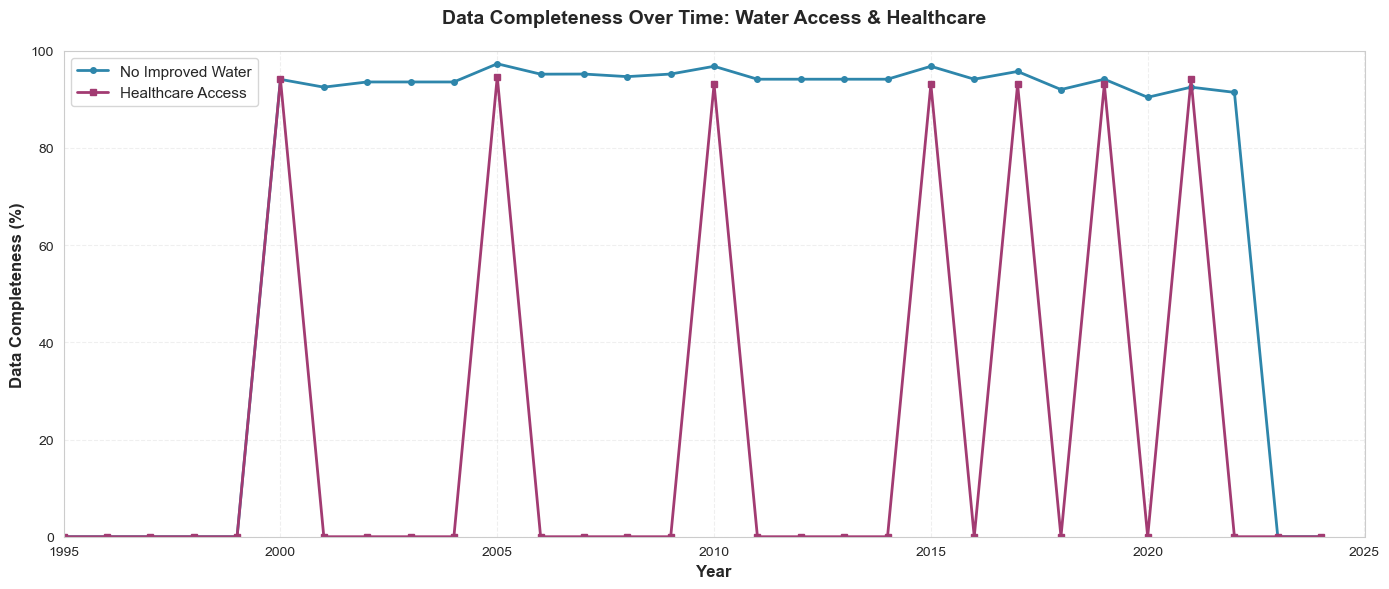

✓ Visualization saved as 'completeness_over_time.png'

RECOMMENDATIONS FOR SUBSETTING

Best years with data for BOTH variables: [2005, 2010, 2015, 2017, 2000]

Detailed statistics for recommended years:

  Year 2005:
    - No Improved Water: 97.3%
    - Healthcare Access: 94.7%
    - Combined Score: 96.0%
    - Total Countries: 187

  Year 2010:
    - No Improved Water: 96.8%
    - Healthcare Access: 93.1%
    - Combined Score: 94.9%
    - Total Countries: 188

  Year 2015:
    - No Improved Water: 96.8%
    - Healthcare Access: 93.1%
    - Combined Score: 94.9%
    - Total Countries: 188

  Year 2017:
    - No Improved Water: 95.7%
    - Healthcare Access: 93.1%
    - Combined Score: 94.4%
    - Total Countries: 188

  Year 2000:
    - No Improved Water: 94.1%
    - Healthcare Access: 94.1%
    - Combined Score: 94.1%
    - Total Countries: 187

CREATING SUBSETS

Option 1: Single best year (2005)
  - Rows: 187
  - Countries: 187
  - No Improved Water completeness: 97.3%
  - Healthcare

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the final cleaned dataset
df = pd.read_csv('../data/interim/final_cleaned.csv')

print("=" * 80)
print("ANALYZING DATA COMPLETENESS BY YEAR")
print("=" * 80)

# Calculate completeness for each year for the two variables
completeness_by_year = df.groupby('Year').agg({
    'No_Improved_Water_Pct': lambda x: (x.notna().sum() / len(x)) * 100,
    'Healthcare_Access_Index': lambda x: (x.notna().sum() / len(x)) * 100,
    'Country Name': 'count'  # Total countries per year
}).rename(columns={'Country Name': 'Total_Countries'})

completeness_by_year = completeness_by_year.reset_index()
completeness_by_year.columns = ['Year', 'No_Improved_Water_Completeness', 
                                  'Healthcare_Access_Completeness', 'Total_Countries']

# Show completeness statistics
print("\nCompleteness by Year (showing years with data):")
print("-" * 80)

# Filter to show only years with some data
years_with_data = completeness_by_year[
    (completeness_by_year['No_Improved_Water_Completeness'] > 0) | 
    (completeness_by_year['Healthcare_Access_Completeness'] > 0)
]

print(years_with_data.to_string(index=False))

# Find best years for each variable
print("\n" + "=" * 80)
print("BEST YEARS FOR EACH VARIABLE")
print("=" * 80)

water_best = completeness_by_year.nlargest(10, 'No_Improved_Water_Completeness')
print("\nTop 10 years for 'No Improved Water' completeness:")
print(water_best[['Year', 'No_Improved_Water_Completeness', 'Total_Countries']].to_string(index=False))

healthcare_best = completeness_by_year.nlargest(10, 'Healthcare_Access_Completeness')
print("\nTop 10 years for 'Healthcare Access' completeness:")
print(healthcare_best[['Year', 'Healthcare_Access_Completeness', 'Total_Countries']].to_string(index=False))

# Find years with good completeness for BOTH variables
print("\n" + "=" * 80)
print("YEARS WITH GOOD COMPLETENESS FOR BOTH VARIABLES")
print("=" * 80)

# Calculate combined score
completeness_by_year['Combined_Score'] = (
    completeness_by_year['No_Improved_Water_Completeness'] + 
    completeness_by_year['Healthcare_Access_Completeness']
) / 2

# Filter years where both have at least some data
both_available = completeness_by_year[
    (completeness_by_year['No_Improved_Water_Completeness'] > 0) & 
    (completeness_by_year['Healthcare_Access_Completeness'] > 0)
].sort_values('Combined_Score', ascending=False)

print("\nYears ranked by combined completeness (both variables):")
print(both_available[['Year', 'No_Improved_Water_Completeness', 
                      'Healthcare_Access_Completeness', 'Combined_Score']].to_string(index=False))

# Visualize completeness over time
print("\n" + "=" * 80)
print("CREATING VISUALIZATION")
print("=" * 80)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(completeness_by_year['Year'], 
        completeness_by_year['No_Improved_Water_Completeness'], 
        marker='o', linewidth=2, markersize=4, label='No Improved Water', color='#2E86AB')
ax.plot(completeness_by_year['Year'], 
        completeness_by_year['Healthcare_Access_Completeness'], 
        marker='s', linewidth=2, markersize=4, label='Healthcare Access', color='#A23B72')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Data Completeness (%)', fontsize=12, fontweight='bold')
ax.set_title('Data Completeness Over Time: Water Access & Healthcare', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(1995, 2025)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../figures/completeness_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'completeness_over_time.png'")

# Recommend best years to subset
print("\n" + "=" * 80)
print("RECOMMENDATIONS FOR SUBSETTING")
print("=" * 80)

# Get the best overlapping years
best_years = both_available.head(5)['Year'].tolist()
print(f"\nBest years with data for BOTH variables: {best_years}")

# Show statistics for recommended years
print("\nDetailed statistics for recommended years:")
for year in best_years:
    year_data = completeness_by_year[completeness_by_year['Year'] == year].iloc[0]
    print(f"\n  Year {int(year)}:")
    print(f"    - No Improved Water: {year_data['No_Improved_Water_Completeness']:.1f}%")
    print(f"    - Healthcare Access: {year_data['Healthcare_Access_Completeness']:.1f}%")
    print(f"    - Combined Score: {year_data['Combined_Score']:.1f}%")
    print(f"    - Total Countries: {int(year_data['Total_Countries'])}")

# Create subsets for the best years
print("\n" + "=" * 80)
print("CREATING SUBSETS")
print("=" * 80)

# Option 1: Single best year
best_single_year = both_available.iloc[0]['Year']
df_best_year = df[df['Year'] == best_single_year].copy()

print(f"\nOption 1: Single best year ({int(best_single_year)})")
print(f"  - Rows: {len(df_best_year)}")
print(f"  - Countries: {df_best_year['Country Name'].nunique()}")
print(f"  - No Improved Water completeness: {(df_best_year['No_Improved_Water_Pct'].notna().sum() / len(df_best_year)) * 100:.1f}%")
print(f"  - Healthcare Access completeness: {(df_best_year['Healthcare_Access_Index'].notna().sum() / len(df_best_year)) * 100:.1f}%")

# Option 2: Top 5 years
df_top5_years = df[df['Year'].isin(best_years)].copy()

print(f"\nOption 2: Top 5 years {best_years}")
print(f"  - Rows: {len(df_top5_years)}")
print(f"  - Countries: {df_top5_years['Country Name'].nunique()}")
print(f"  - No Improved Water completeness: {(df_top5_years['No_Improved_Water_Pct'].notna().sum() / len(df_top5_years)) * 100:.1f}%")
print(f"  - Healthcare Access completeness: {(df_top5_years['Healthcare_Access_Index'].notna().sum() / len(df_top5_years)) * 100:.1f}%")

# Option 3: All years with both variables available
all_both_years = both_available['Year'].tolist()
df_all_both = df[df['Year'].isin(all_both_years)].copy()

print(f"\nOption 3: All years with both variables ({len(all_both_years)} years)")
print(f"  - Years: {min(all_both_years)}-{max(all_both_years)}")
print(f"  - Rows: {len(df_all_both)}")
print(f"  - Countries: {df_all_both['Country Name'].nunique()}")
print(f"  - No Improved Water completeness: {(df_all_both['No_Improved_Water_Pct'].notna().sum() / len(df_all_both)) * 100:.1f}%")
print(f"  - Healthcare Access completeness: {(df_all_both['Healthcare_Access_Index'].notna().sum() / len(df_all_both)) * 100:.1f}%")

# Save the subsets
#df_best_year.to_csv('dataset_best_year.csv', index=False)
#df_top5_years.to_csv('dataset_top5_years.csv', index=False)
df_all_both.to_csv('../data/interim/dataset_all_both_variables.csv', index=False)

print("\n" + "=" * 80)
print("✓ Subsets saved:")
#print(f"  - dataset_best_year.csv (year {int(best_single_year)})")
#print(f"  - dataset_top5_years.csv (years {best_years})")
print(f"  - dataset_all_both_variables.csv (all years with both variables)")
print("=" * 80)

### Temporal Coverage and Imputation Strategy

A preliminary audit of missing values showed that data coverage is most consistent for the years 2000, 2005, 2010, 2015, 2017, 2019, and 2021.
These years were therefore selected for exploratory trend analysis (EDA), allowing for examination of global development dynamics over two decades.

For clustering, a cross-sectional snapshot for 2019 was selected, balancing recency and data completeness.

Imputation Approach:

To ensure maximum data coverage without distorting country-level relationships:

If data is missing, the value from the nearest previous available year would be used.

If no temporal data existed for a given country, the gap was filled using the regional median.

This strategy preserves the global distribution of values while minimizing bias that could arise from extrapolation or random imputation.

Rationale:

Selecting discrete benchmark years avoids the noise of annual fluctuations and highlights long-term patterns.

Using the 2019 snapshot aligns all indicators temporally for clustering, ensuring comparability across countries.

Regional median imputation maintains coherence in regional trends and reduces distortion from extreme outliers.

In [18]:
import pandas as pd
import numpy as np

# Load the datasets
df_all_both = pd.read_csv('../data/interim/dataset_all_both_variables.csv')
df_full = pd.read_csv('../data/interim/final_cleaned.csv')

print("=" * 80)
print("STEP 1: REMOVE COLUMNS AND COUNTRIES")
print("=" * 80)

# Remove columns
columns_to_remove = ['Unnamed: 0', 'Country Code']
df_all_both = df_all_both.drop(columns=[col for col in columns_to_remove if col in df_all_both.columns])
df_full = df_full.drop(columns=[col for col in columns_to_remove if col in df_full.columns])

print(f"Removed columns: {columns_to_remove}")

# Remove specific countries
countries_to_remove = [
    'Saint Pierre and Miquelon',
    'Saint Lucia',
    'Democratic Republic of Congo',
    'Channel Islands'
]

print(f"\nRemoving countries: {countries_to_remove}")

# Check which countries exist
for country in countries_to_remove:
    count_both = len(df_all_both[df_all_both['Country Name'] == country])
    count_full = len(df_full[df_full['Country Name'] == country])
    print(f"  - {country}: {count_both} rows in subset, {count_full} rows in full dataset")

df_all_both = df_all_both[~df_all_both['Country Name'].isin(countries_to_remove)]
df_full = df_full[~df_full['Country Name'].isin(countries_to_remove)]

print(f"\nAfter removal:")
print(f"  - Subset: {len(df_all_both)} rows, {df_all_both['Country Name'].nunique()} countries")
print(f"  - Full dataset: {len(df_full)} rows, {df_full['Country Name'].nunique()} countries")

print("\n" + "=" * 80)
print("STEP 2: ANALYZE MISSING DATA")
print("=" * 80)

# Check missing data in the subset
missing_summary = {}
for col in df_all_both.columns:
    if col not in ['Country Name', 'Year']:
        missing_count = df_all_both[col].isna().sum()
        missing_pct = (missing_count / len(df_all_both)) * 100
        missing_summary[col] = {
            'missing_count': missing_count,
            'missing_pct': missing_pct
        }

print("\nMissing data in subset (years 2000, 2005, 2010, 2015, 2017, 2019, 2021):")
for col, stats in missing_summary.items():
    print(f"  - {col}: {stats['missing_count']} missing ({stats['missing_pct']:.1f}%)")

print("\n" + "=" * 80)
print("STEP 3: FILL GAPS USING MULTIPLE STRATEGIES")
print("=" * 80)

# Create a copy for filling
df_filled = df_all_both.copy()

# Define regions for median imputation (simplified geographic grouping)
region_mapping = {
    # Africa
    'Algeria': 'Africa', 'Angola': 'Africa', 'Benin': 'Africa', 'Botswana': 'Africa',
    'Burkina Faso': 'Africa', 'Burundi': 'Africa', 'Cameroon': 'Africa', 'Cape Verde': 'Africa',
    'Chad': 'Africa', 'Comoros': 'Africa', 'Cote d\'Ivoire': 'Africa', 'Djibouti': 'Africa',
    'Equatorial Guinea': 'Africa', 'Eritrea': 'Africa', 'Eswatini': 'Africa', 'Ethiopia': 'Africa',
    'Gabon': 'Africa', 'Gambia': 'Africa', 'Ghana': 'Africa', 'Guinea': 'Africa',
    'Guinea-Bissau': 'Africa', 'Kenya': 'Africa', 'Lesotho': 'Africa', 'Liberia': 'Africa',
    'Libya': 'Africa', 'Madagascar': 'Africa', 'Malawi': 'Africa', 'Mali': 'Africa',
    'Mauritania': 'Africa', 'Mauritius': 'Africa', 'Morocco': 'Africa', 'Mozambique': 'Africa',
    'Namibia': 'Africa', 'Niger': 'Africa', 'Nigeria': 'Africa', 'Republic of Congo': 'Africa',
    'Rwanda': 'Africa', 'Sao Tome and Principe': 'Africa', 'Senegal': 'Africa', 'Seychelles': 'Africa',
    'Sierra Leone': 'Africa', 'Somalia': 'Africa', 'Sudan': 'Africa', 'Tanzania': 'Africa',
    'Togo': 'Africa', 'Tunisia': 'Africa', 'Uganda': 'Africa', 'Zambia': 'Africa', 'Zimbabwe': 'Africa',
    
    # Asia
    'Afghanistan': 'Asia', 'Armenia': 'Asia', 'Azerbaijan': 'Asia', 'Bahrain': 'Asia',
    'Bangladesh': 'Asia', 'Bhutan': 'Asia', 'Brunei': 'Asia', 'Cambodia': 'Asia',
    'China': 'Asia', 'Georgia': 'Asia', 'India': 'Asia', 'Indonesia': 'Asia',
    'Iran': 'Asia', 'Iraq': 'Asia', 'Israel': 'Asia', 'Japan': 'Asia',
    'Jordan': 'Asia', 'Kazakhstan': 'Asia', 'Kuwait': 'Asia', 'Kyrgyzstan': 'Asia',
    'Laos': 'Asia', 'Lebanon': 'Asia', 'Malaysia': 'Asia', 'Maldives': 'Asia',
    'Mongolia': 'Asia', 'Myanmar': 'Asia', 'Nepal': 'Asia', 'North Korea': 'Asia',
    'Oman': 'Asia', 'Pakistan': 'Asia', 'Philippines': 'Asia', 'Qatar': 'Asia',
    'Saudi Arabia': 'Asia', 'Singapore': 'Asia', 'South Korea': 'Asia', 'Sri Lanka': 'Asia',
    'Syria': 'Asia', 'Taiwan': 'Asia', 'Tajikistan': 'Asia', 'Thailand': 'Asia',
    'Turkey': 'Asia', 'Turkmenistan': 'Asia', 'United Arab Emirates': 'Asia', 'Uzbekistan': 'Asia',
    'Vietnam': 'Asia', 'Yemen': 'Asia',
    
    # Europe
    'Albania': 'Europe', 'Andorra': 'Europe', 'Austria': 'Europe', 'Belarus': 'Europe',
    'Belgium': 'Europe', 'Bosnia and Herzegovina': 'Europe', 'Bulgaria': 'Europe', 'Croatia': 'Europe',
    'Cyprus': 'Europe', 'Czechia': 'Europe', 'Denmark': 'Europe', 'Estonia': 'Europe',
    'Finland': 'Europe', 'France': 'Europe', 'Germany': 'Europe', 'Gibraltar': 'Europe',
    'Greece': 'Europe', 'Greenland': 'Europe', 'Hungary': 'Europe', 'Iceland': 'Europe',
    'Ireland': 'Europe', 'Italy': 'Europe', 'Jersey': 'Europe', 'Latvia': 'Europe',
    'Liechtenstein': 'Europe', 'Lithuania': 'Europe', 'Luxembourg': 'Europe', 'Malta': 'Europe',
    'Moldova': 'Europe', 'Monaco': 'Europe', 'Montenegro': 'Europe', 'Netherlands': 'Europe',
    'Norway': 'Europe', 'Poland': 'Europe', 'Portugal': 'Europe', 'Romania': 'Europe',
    'Russia': 'Europe', 'San Marino': 'Europe', 'Serbia': 'Europe', 'Slovakia': 'Europe',
    'Slovenia': 'Europe', 'Spain': 'Europe', 'Sweden': 'Europe', 'Switzerland': 'Europe',
    'Ukraine': 'Europe', 'United Kingdom': 'Europe', 'Vatican': 'Europe',
    
    # Americas
    'Antigua and Barbuda': 'Americas', 'Argentina': 'Americas', 'Bahamas': 'Americas', 'Barbados': 'Americas',
    'Belize': 'Americas', 'Bermuda': 'Americas', 'Bolivia': 'Americas', 'Brazil': 'Americas',
    'British Virgin Islands': 'Americas', 'Canada': 'Americas', 'Cayman Islands': 'Americas', 'Chile': 'Americas',
    'Colombia': 'Americas', 'Costa Rica': 'Americas', 'Cuba': 'Americas', 'Dominica': 'Americas',
    'Dominican Republic': 'Americas', 'Ecuador': 'Americas', 'El Salvador': 'Americas', 'Grenada': 'Americas',
    'Guatemala': 'Americas', 'Guyana': 'Americas', 'Haiti': 'Americas', 'Honduras': 'Americas',
    'Jamaica': 'Americas', 'Mexico': 'Americas', 'Nicaragua': 'Americas', 'Panama': 'Americas',
    'Paraguay': 'Americas', 'Peru': 'Americas', 'Suriname': 'Americas', 'Trinidad and Tobago': 'Americas',
    'United States': 'Americas', 'Uruguay': 'Americas', 'Venezuela': 'Americas',
    
    # Oceania
    'Australia': 'Oceania', 'Fiji': 'Oceania', 'Guam': 'Oceania', 'Kiribati': 'Oceania',
    'Marshall Islands': 'Oceania', 'Nauru': 'Oceania', 'New Zealand': 'Oceania', 'Palau': 'Oceania',
    'Papua New Guinea': 'Oceania', 'Pitcairn': 'Oceania', 'Samoa': 'Oceania', 'Solomon Islands': 'Oceania',
    'Tonga': 'Oceania', 'Tuvalu': 'Oceania', 'Vanuatu': 'Oceania',
}

df_filled['Region'] = df_filled['Country Name'].map(region_mapping)

# Strategy 1: Forward fill from previous years in full dataset
print("\nStrategy 1: Forward fill from previous years")
variables_to_fill = ['Population_Total', 'Population_Density', 'Population_65_Plus_Pct',
                     'Air_Transport_Passengers', 'Urban_Population_Pct', 
                     'Healthcare_Access_Index', 'HDI', 'No_Improved_Water_Pct']

filled_counts = {var: 0 for var in variables_to_fill}

for idx, row in df_filled.iterrows():
    country = row['Country Name']
    year = row['Year']
    
    for var in variables_to_fill:
        if pd.isna(row[var]):
            # Look for data from previous years (up to 5 years back)
            for lookback in range(1, 6):
                prev_year = year - lookback
                prev_data = df_full[(df_full['Country Name'] == country) & 
                                   (df_full['Year'] == prev_year)]
                
                if len(prev_data) > 0 and pd.notna(prev_data[var].iloc[0]):
                    df_filled.at[idx, var] = prev_data[var].iloc[0]
                    filled_counts[var] += 1
                    break

print("Filled from previous years:")
for var, count in filled_counts.items():
    print(f"  - {var}: {count} values")

# Strategy 2: Use regional medians for remaining gaps
print("\nStrategy 2: Fill remaining gaps with regional medians")
regional_filled_counts = {var: 0 for var in variables_to_fill}

for var in variables_to_fill:
    # Calculate regional medians for each year
    for year in df_filled['Year'].unique():
        year_data = df_filled[df_filled['Year'] == year]
        
        for region in df_filled['Region'].unique():
            if pd.notna(region):
                region_median = year_data[year_data['Region'] == region][var].median()
                
                if pd.notna(region_median):
                    # Fill missing values in this region and year
                    mask = (df_filled['Year'] == year) & \
                           (df_filled['Region'] == region) & \
                           (df_filled[var].isna())
                    
                    count_before = df_filled[mask][var].isna().sum()
                    df_filled.loc[mask, var] = region_median
                    regional_filled_counts[var] += count_before

print("Filled with regional medians:")
for var, count in regional_filled_counts.items():
    print(f"  - {var}: {count} values")

# Remove the Region column
df_filled = df_filled.drop(columns=['Region'])

print("\n" + "=" * 80)
print("STEP 4: FINAL RESULTS")
print("=" * 80)

# Compare before and after
print("\nData completeness comparison:")
print(f"{'Variable':<30} {'Before':<15} {'After':<15} {'Improvement':<15}")
print("-" * 75)

for col in df_all_both.columns:
    if col not in ['Country Name', 'Year']:
        before_pct = (df_all_both[col].notna().sum() / len(df_all_both)) * 100
        after_pct = (df_filled[col].notna().sum() / len(df_filled)) * 100
        improvement = after_pct - before_pct
        print(f"{col:<30} {before_pct:>6.2f}%        {after_pct:>6.2f}%        {improvement:>+6.2f}%")

overall_before = (df_all_both.notna().sum().sum() / (len(df_all_both) * len(df_all_both.columns))) * 100
overall_after = (df_filled.notna().sum().sum() / (len(df_filled) * len(df_filled.columns))) * 100

print("-" * 75)
print(f"{'Overall':<30} {overall_before:>6.2f}%        {overall_after:>6.2f}%        {overall_after - overall_before:>+6.2f}%")

print(f"\nFinal dataset:")
print(f"  - Rows: {len(df_filled)}")
print(f"  - Countries: {df_filled['Country Name'].nunique()}")
print(f"  - Years: {sorted(df_filled['Year'].unique())}")
print(f"  - Columns: {list(df_filled.columns)}")

# Show sample
print("\n" + "=" * 80)
print("SAMPLE OF FILLED DATA (2015)")
print("=" * 80)
sample = df_filled[df_filled['Year'] == 2015].head(10)
print(sample.to_string(index=False))

# Save the filled dataset
df_filled.to_csv('../data/interim/dataset_filled_complete.csv', index=False)

print("\n" + "=" * 80)
print("✓ Filled dataset saved as 'dataset_filled_complete.csv'")
print("=" * 80)

STEP 1: REMOVE COLUMNS AND COUNTRIES
Removed columns: ['Unnamed: 0', 'Country Code']

Removing countries: ['Saint Pierre and Miquelon', 'Saint Lucia', 'Democratic Republic of Congo', 'Channel Islands']
  - Saint Pierre and Miquelon: 4 rows in subset, 15 rows in full dataset
  - Saint Lucia: 7 rows in subset, 65 rows in full dataset
  - Democratic Republic of Congo: 7 rows in subset, 65 rows in full dataset
  - Channel Islands: 7 rows in subset, 65 rows in full dataset

After removal:
  - Subset: 1288 rows, 184 countries
  - Full dataset: 11965 rows, 189 countries

STEP 2: ANALYZE MISSING DATA

Missing data in subset (years 2000, 2005, 2010, 2015, 2017, 2019, 2021):
  - Population_Total: 32 missing (2.5%)
  - Population_Density: 39 missing (3.0%)
  - Population_65_Plus_Pct: 25 missing (1.9%)
  - Air_Transport_Passengers: 298 missing (23.1%)
  - Urban_Population_Pct: 24 missing (1.9%)
  - Healthcare_Access_Index: 73 missing (5.7%)
  - HDI: 111 missing (8.6%)
  - No_Improved_Water_Pct: 54

# Exploratory Data Analysis

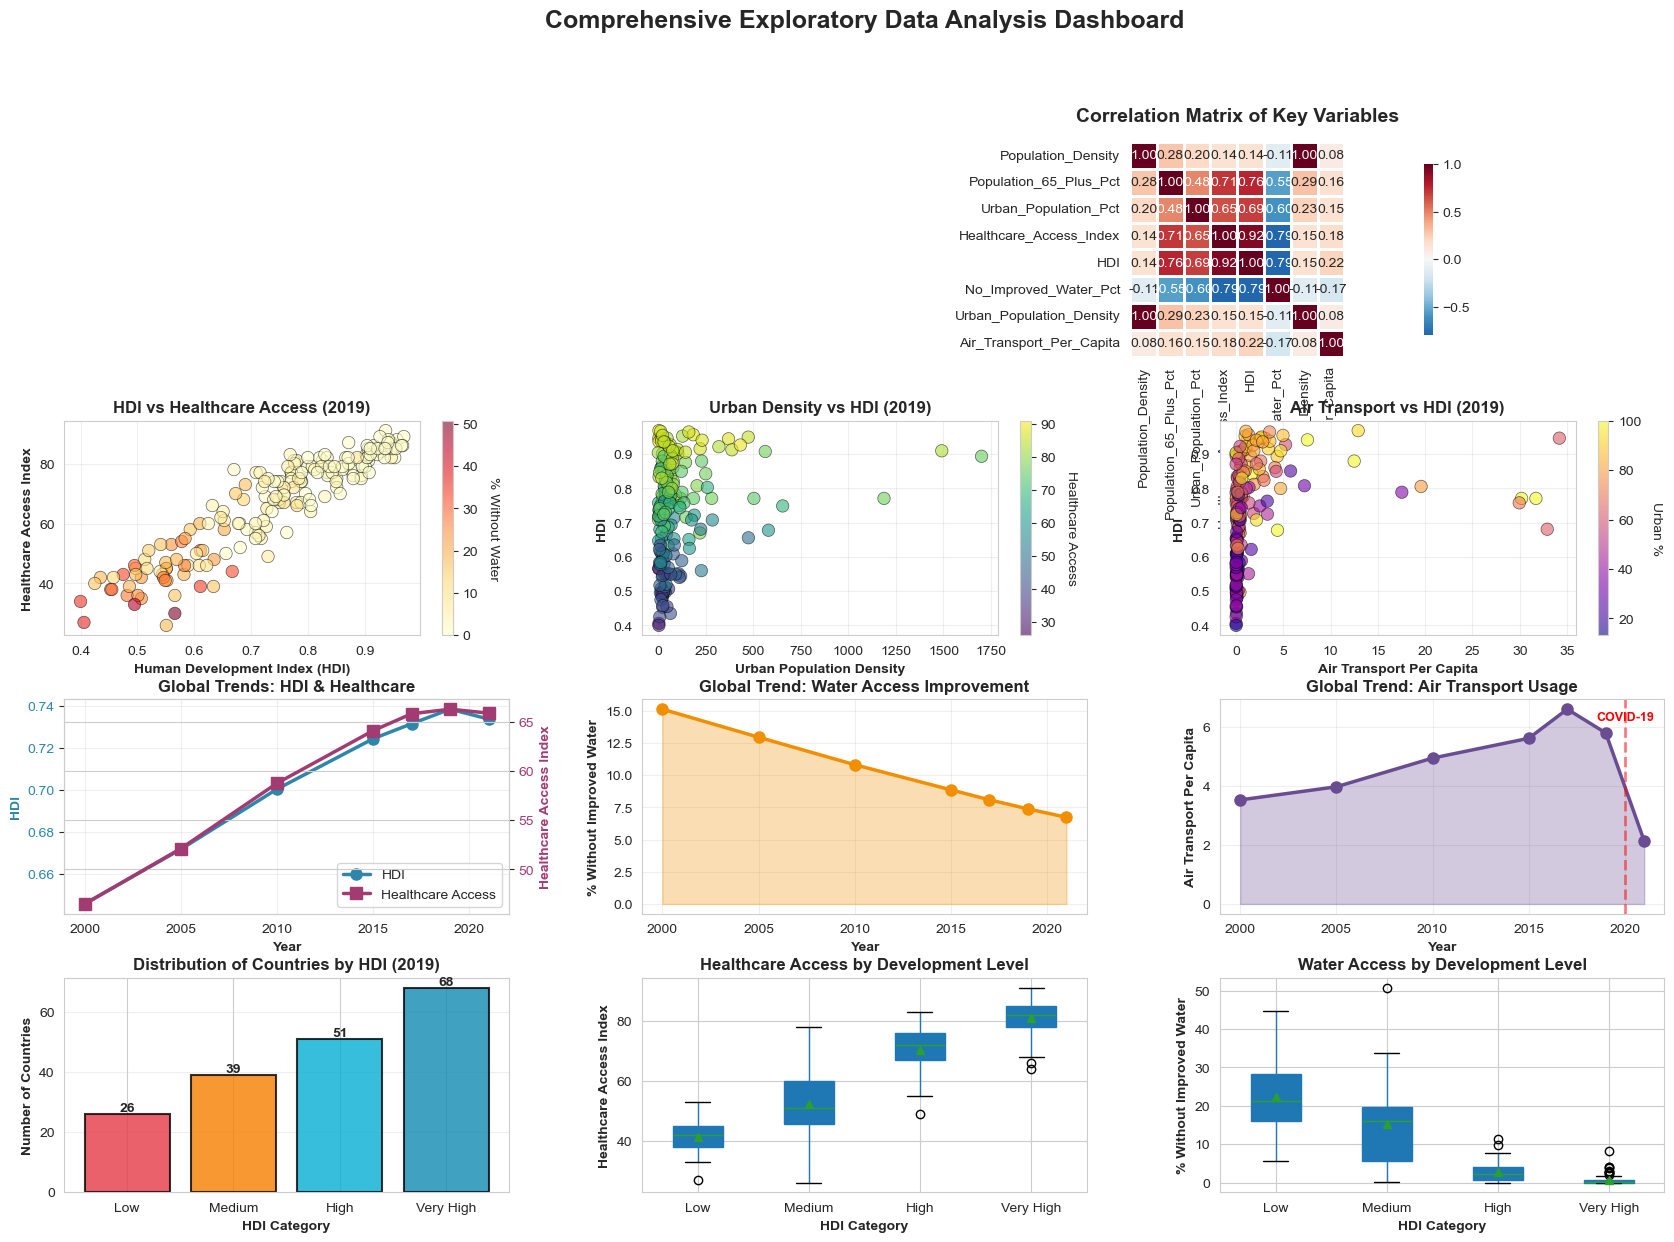

✓ Comprehensive EDA dashboard saved as 'eda_dashboard.png'


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('../data/interim/dataset_filled_complete.csv')

# Create new columns
# 1. Urban Population Density = Population Density × Urban Population %
df['Urban_Population_Density'] = df['Population_Density'] * (df['Urban_Population_Pct'] / 100)

# 2. Air Transport per Capita = Air Transport Passengers / Population Total
df['Air_Transport_Per_Capita'] = df['Air_Transport_Passengers'] / df['Population_Total']

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Correlation Heatmap
ax1 = fig.add_subplot(gs[0, :])
correlation_cols = [
    'Population_Density', 'Population_65_Plus_Pct', 'Urban_Population_Pct',
    'Healthcare_Access_Index', 'HDI', 'No_Improved_Water_Pct',
    'Urban_Population_Density', 'Air_Transport_Per_Capita'
]
corr_matrix = df[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax1)
ax1.set_title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold', pad=15)

# 2. HDI vs Healthcare Access (2019)
ax2 = fig.add_subplot(gs[1, 0])
df_2019 = df[df['Year'] == 2019]
scatter = ax2.scatter(df_2019['HDI'], df_2019['Healthcare_Access_Index'],
                     c=df_2019['No_Improved_Water_Pct'], cmap='YlOrRd',
                     s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Human Development Index (HDI)', fontweight='bold')
ax2.set_ylabel('Healthcare Access Index', fontweight='bold')
ax2.set_title('HDI vs Healthcare Access (2019)', fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('% Without Water', rotation=270, labelpad=15)
ax2.grid(True, alpha=0.3)

# 3. Urban Population Density vs HDI
ax3 = fig.add_subplot(gs[1, 1])
# Remove extreme outliers for better visualization
df_2019_filtered = df_2019[df_2019['Urban_Population_Density'] < 2000]
scatter2 = ax3.scatter(df_2019_filtered['Urban_Population_Density'], 
                      df_2019_filtered['HDI'],
                      c=df_2019_filtered['Healthcare_Access_Index'], 
                      cmap='viridis', s=80, alpha=0.6, 
                      edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Urban Population Density', fontweight='bold')
ax3.set_ylabel('HDI', fontweight='bold')
ax3.set_title('Urban Density vs HDI (2019)', fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=ax3)
cbar2.set_label('Healthcare Access', rotation=270, labelpad=15)
ax3.grid(True, alpha=0.3)

# 4. Air Transport Per Capita vs HDI
ax4 = fig.add_subplot(gs[1, 2])
df_2019_air = df_2019[df_2019['Air_Transport_Per_Capita'] < 50]  # Remove extreme outliers
scatter3 = ax4.scatter(df_2019_air['Air_Transport_Per_Capita'], 
                      df_2019_air['HDI'],
                      c=df_2019_air['Urban_Population_Pct'], 
                      cmap='plasma', s=80, alpha=0.6,
                      edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Air Transport Per Capita', fontweight='bold')
ax4.set_ylabel('HDI', fontweight='bold')
ax4.set_title('Air Transport vs HDI (2019)', fontweight='bold')
cbar3 = plt.colorbar(scatter3, ax=ax4)
cbar3.set_label('Urban %', rotation=270, labelpad=15)
ax4.grid(True, alpha=0.3)

# 5. Temporal trends - HDI and Healthcare
ax5 = fig.add_subplot(gs[2, 0])
trends = df.groupby('Year').agg({
    'HDI': 'mean',
    'Healthcare_Access_Index': 'mean'
})
ax5_twin = ax5.twinx()
line1 = ax5.plot(trends.index, trends['HDI'], marker='o', linewidth=2.5, 
                 color='#2E86AB', label='HDI', markersize=8)
line2 = ax5_twin.plot(trends.index, trends['Healthcare_Access_Index'], 
                      marker='s', linewidth=2.5, color='#A23B72', 
                      label='Healthcare Access', markersize=8)
ax5.set_xlabel('Year', fontweight='bold')
ax5.set_ylabel('HDI', fontweight='bold', color='#2E86AB')
ax5_twin.set_ylabel('Healthcare Access Index', fontweight='bold', color='#A23B72')
ax5.set_title('Global Trends: HDI & Healthcare', fontweight='bold')
ax5.tick_params(axis='y', labelcolor='#2E86AB')
ax5_twin.tick_params(axis='y', labelcolor='#A23B72')
ax5.grid(True, alpha=0.3)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax5.legend(lines, labels, loc='lower right')

# 6. Temporal trends - Water Access
ax6 = fig.add_subplot(gs[2, 1])
water_trends = df.groupby('Year')['No_Improved_Water_Pct'].mean()
ax6.plot(water_trends.index, water_trends.values, marker='o', 
         linewidth=2.5, color='#F18F01', markersize=8)
ax6.fill_between(water_trends.index, water_trends.values, alpha=0.3, color='#F18F01')
ax6.set_xlabel('Year', fontweight='bold')
ax6.set_ylabel('% Without Improved Water', fontweight='bold')
ax6.set_title('Global Trend: Water Access Improvement', fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. Air Transport Per Capita trend
ax7 = fig.add_subplot(gs[2, 2])
air_trends = df.groupby('Year')['Air_Transport_Per_Capita'].mean()
ax7.plot(air_trends.index, air_trends.values, marker='o', 
         linewidth=2.5, color='#6A4C93', markersize=8)
ax7.fill_between(air_trends.index, air_trends.values, alpha=0.3, color='#6A4C93')
ax7.set_xlabel('Year', fontweight='bold')
ax7.set_ylabel('Air Transport Per Capita', fontweight='bold')
ax7.set_title('Global Trend: Air Transport Usage', fontweight='bold')
ax7.grid(True, alpha=0.3)
ax7.axvline(x=2020, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax7.text(2020, ax7.get_ylim()[1]*0.9, 'COVID-19', ha='center', 
         fontsize=9, color='red', fontweight='bold')

# 8. HDI Categories Distribution
ax8 = fig.add_subplot(gs[3, 0])
df_2019['HDI_Category'] = pd.cut(
    df_2019['HDI'],
    bins=[0, 0.55, 0.70, 0.80, 1.0],
    labels=['Low', 'Medium', 'High', 'Very High']
)
hdi_counts = df_2019['HDI_Category'].value_counts().sort_index()
colors = ['#E63946', '#F77F00', '#06AED5', '#118AB2']
bars = ax8.bar(hdi_counts.index, hdi_counts.values, color=colors, 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax8.set_xlabel('HDI Category', fontweight='bold')
ax8.set_ylabel('Number of Countries', fontweight='bold')
ax8.set_title('Distribution of Countries by HDI (2019)', fontweight='bold')
ax8.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 9. Box plot - Healthcare by HDI Category
ax9 = fig.add_subplot(gs[3, 1])
df_2019.boxplot(column='Healthcare_Access_Index', by='HDI_Category', ax=ax9,
                patch_artist=True, showmeans=True)
ax9.set_xlabel('HDI Category', fontweight='bold')
ax9.set_ylabel('Healthcare Access Index', fontweight='bold')
ax9.set_title('Healthcare Access by Development Level', fontweight='bold')
plt.sca(ax9)
plt.xticks(rotation=0)
ax9.get_figure().suptitle('')  # Remove default title

# 10. Box plot - Water Access by HDI Category
ax10 = fig.add_subplot(gs[3, 2])
df_2019.boxplot(column='No_Improved_Water_Pct', by='HDI_Category', ax=ax10,
                patch_artist=True, showmeans=True)
ax10.set_xlabel('HDI Category', fontweight='bold')
ax10.set_ylabel('% Without Improved Water', fontweight='bold')
ax10.set_title('Water Access by Development Level', fontweight='bold')
plt.sca(ax10)
plt.xticks(rotation=0)
ax10.get_figure().suptitle('')  # Remove default title

plt.suptitle('Comprehensive Exploratory Data Analysis Dashboard', 
             fontsize=18, fontweight='bold', y=0.995)

plt.savefig('../figures/eda_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive EDA dashboard saved as 'eda_dashboard.png'")

# EDA Report

Overview

This exploratory data analysis examines global country-level socioeconomic and development indicators, revealing strong correlations between key metrics and significant global trends from 2000 to 2021. The analysis informed the decision to apply Principal Component Analysis (PCA) to reduce multicollinearity among highly correlated development indicators.

1. Correlation Analysis
The correlation matrix reveals 3 distinct groups of highly correlated variables:

Development Indicators Cluster (Strong Positive Correlations):

- HDI and Healthcare_Access_Index: r = 0.92 (very high)
- HDI and No_Improved_Water_Pct: r = -0.79 (strong negative)
- Healthcare_Access_Index and No_Improved_Water_Pct: r = -0.79 (strong negative)

*Key Insight:* 

*Multicollinearity Problem*

Correlations ~0.8 and higher indicate severe redundancy. 

These three variables are measuring essentially the same underlying construct - overall development level. 
Countries with high HDI almost always have high healthcare access and low percentages of population without improved water access.

To manage this problem, we're going to create a single composite "PCA_Development" score that's easier to interpret than three separate but redundant metrics.

2. Urbanization:
Urban_Population_Pct and Population_Density are weakly correlated: r = 0.23 (weak positive)

Since the spatial distribution of population is often heterogeneous, especially in countries with large uninhabited areas, the national average density does not adequately represent the actual human contact potential. Therefore, population density would be scaled by the urbanization rate to approximate "effective" population density - density within areas where most people actually live and interact.

3. International Mobility Indicator:

Air_Transport_Per_Capita shows moderate correlations with development indicators (r = 0.22)
Relatively independent from other variables, capturing unique information about economic population mobility that influences the speed of epidemic spreding

4. Bivariate Relationship Analysis:

*HDI vs Healthcare Access (2019)*

Relationship: strong positive correlation

Observations:

- Clear linear relationship with low scatter
- Countries cluster along a tight diagonal band
- Color gradient (Urban_Population_Pct) shows urbanization increases with development
- No countries have high HDI with low healthcare access, or vice versa
- A few outliers exist with moderate HDI but varying healthcare access (20-40 range)

Interpretation: Healthcare access is essentially a proxy for HDI. This validates the PCA decision - these metrics are measuring the same phenomenon.

*Urban Density vs HDI (2019)*

Relationship: weak positive correlation with high variance

Observations:

- Wide scatter
- Countries with HDI < 0.6 urban show densities ranging from 30 to 1,800
- High HDI countries (>0.8) tend to cluster at moderate urban densities (200-600)
- Color gradient shows healthcare access increases with both HDI and urban density

Outliers: Several countries with very high urban density (>1,500) but moderate HDI (0.6-0.8)

Interpretation: Urbanization alone doesn't guarantee development. Some highly urbanized countries remain at moderate development levels, possibly due to rapid, unplanned urbanization or city-state configurations.

*Air Transport vs HDI (2019)*

Relationship: Weak positive correlation with extreme outliers

Observations:

- Most countries cluster at low air transport per capita regardless of HDI
- Extreme outliers: 3-4 countries with air transport per capita >25-35
- High HDI countries show more variance in air transport usage
- Urban density doesn't strongly predict air transport usage

Interpretation: Air transport per capita captures unique information beyond development level. 

Outliers likely include:

- Small island nations dependent on air travel
- Major aviation hubs (UAE, Singapore, Qatar)
- Tourism-dependent economies
- This validates including this feature in clustering - it's not redundant with development indicators.

5. Global Temporal Trends (2000-2021)

HDI & Healthcare Access Improvement: Consistent upward trajectory with slight deceleration

HDI: Increased from 0.65 (2000) to 0.74 (2020), then slight decline

Healthcare Access: Rose from 47 (2000) to 66 (2020), then slight decline

Both metrics move in perfect lockstep (confirming high correlation)

Growth rate: Faster improvement 2000-2010, slower in2010-2020

Post-2020 dip: Likely COVID-19 impact on healthcare systems and development

Interpretation: Global development has been steadily improving but may be plateauing. The pandemic reversed some gains.

Water Access Improvement: Dramatic improvement with diminishing returns

% Without Improved Water: Decreased from 15% (2000) to 6.5% (2023)

56% reduction in population without water access over 21 year

Air Transport Usage: Steady growth with COVID-19 collapse

Increased from 3.5 (2000) to 6.2 (2019) passengers per capita
(77% growth over 19 years)

Dramatic collapse in 2020-2021 due to the pandemic
Partial recovery by 2021 but still 60% below 2019 peak

Interpretation:

Air travel was a strong indicator of globalization, economic connectivity and international mobility

COVID-19 had a catastrophic impact on aviation

Recovery is slow, suggesting lasting behavioral changes or economic impacts

6. Distribution Analysis

Countries by HDI Category (2019)

Distribution:
 - Low HDI (<0.55): 26 countries (14%)
- Medium HDI (0.55-0.70): 39 countries (21%)
- High HDI (0.70-0.80): 51 countries (28%)
- Very High HDI (>0.80): 68 countries (37%)

Key Insights:

Majority of countries (65%) are in High or Very High categories

Distribution is right-skewed towards higher development

Only 14% remain in Low HDI category

Suggests global development has lifted most countries above lowest tier

Healthcare Access by Development Level: Clear stratification with increasing variance at higher levels

Observations:

Low HDI: Median ~44, range 25-54, tight distribution

Medium HDI: Median ~52, range 25-80, high variance

High HDI: Median ~74, range 50-85, moderate variance

Very High HDI: Median ~85, range 67-95, tight distribution at top

Key Insights:

- Healthcare access increases predictably with HDI category
- Medium HDI shows highest variance - countries at similar development levels have vastly different healthcare systems
- Very High HDI countries have converged on near-universal healthcare access
- Several outliers in Medium/High categories with unexpectedly low healthcare access

Water Access by Development Level: Inverse relationship with dramatic improvement at higher development

Observations:

Low HDI: Median ~21%, range 6-45% without improved water

Medium HDI: Median ~17%, range 0-34%, high variance

High HDI: Median ~3%, range 0-9%, tight distribution

Very High HDI: Median ~1%, range 0-5%, near-universal access

Key Insights:

- Water access improves faster than healthcare as countries develop
- High/Very High HDI countries have essentially solved water access (median <3%)
- Low HDI countries still face major challenges (25% without access)

Outliers: A few Very High HDI countries still have 5-8% without improved water (possibly rural/remote populations)

7. Final Feature Set For Clustring:

PCA_Development: Composite of HDI, healthcare, and water access

Adj_PopDensity: Population density × urbanization (captures urban concentration)

AirTransportPerCapita: Economic connectivity and globalization

Population_65_Plus_Pct: Demographic maturity

Rationale for feature selection:

Low correlation between features (avoiding redundancy)

Complementary information: Development, urbanization, connectivity, demographics

Meaningful variance: Each captures different aspects of country profiles

8. Conclusions

1) Development indicators are highly redundant - PCA is essential to avoid multicollinearity
2) Global development has improved significantly (2000-2020)
3) COVID-19 had major impact on air transport and slight reversal on development metrics
4) Countries cluster naturally into development tiers, but with specific outliers
5) Air transport captures unique information beyond traditional development metrics
6) Water access is a development success story - dramatic improvement globally
7) Healthcare access remains variable even among similarly developed countries
8) This EDA validates the feature engineering and PCA approach used in the subsequent clustering analysis, ensuring the final model uses independent, meaningful features that capture different dimensions of country profiles.

# Clustering, Evaluation and Algorithm Selection


PCA TRANSFORMATION COMPLETE
Explained variance by first PC: 0.8892
Dropped columns: ['HDI', 'Healthcare_Access_Index', 'No_Improved_Water_Pct']
Added column: PCA_Development

DATA SUBSET FOR YEAR 2019
Number of countries in 2019: 184

Countries with complete data for clustering: 184

CLUSTERING ANALYSIS

--- KMeans Clustering ---
k=2: Silhouette=0.4635, Davies-Bouldin=0.9765
k=3: Silhouette=0.4651, Davies-Bouldin=0.6445
k=4: Silhouette=0.4916, Davies-Bouldin=0.5321
k=5: Silhouette=0.5285, Davies-Bouldin=0.5108
k=6: Silhouette=0.5373, Davies-Bouldin=0.4443

--- Agglomerative Clustering ---
k=2: Silhouette=0.4509, Davies-Bouldin=1.0103
k=3: Silhouette=0.4583, Davies-Bouldin=0.6693
k=4: Silhouette=0.4805, Davies-Bouldin=0.5663
k=5: Silhouette=0.4957, Davies-Bouldin=0.5485
k=6: Silhouette=0.5057, Davies-Bouldin=0.4896

--- DBSCAN Clustering ---
eps=0.3, min_samples=3: clusters=3, noise=26, Silhouette=0.4419, Davies-Bouldin=0.5126
eps=0.3, min_samples=5: clusters=3, noise=33, Silhouette=0.

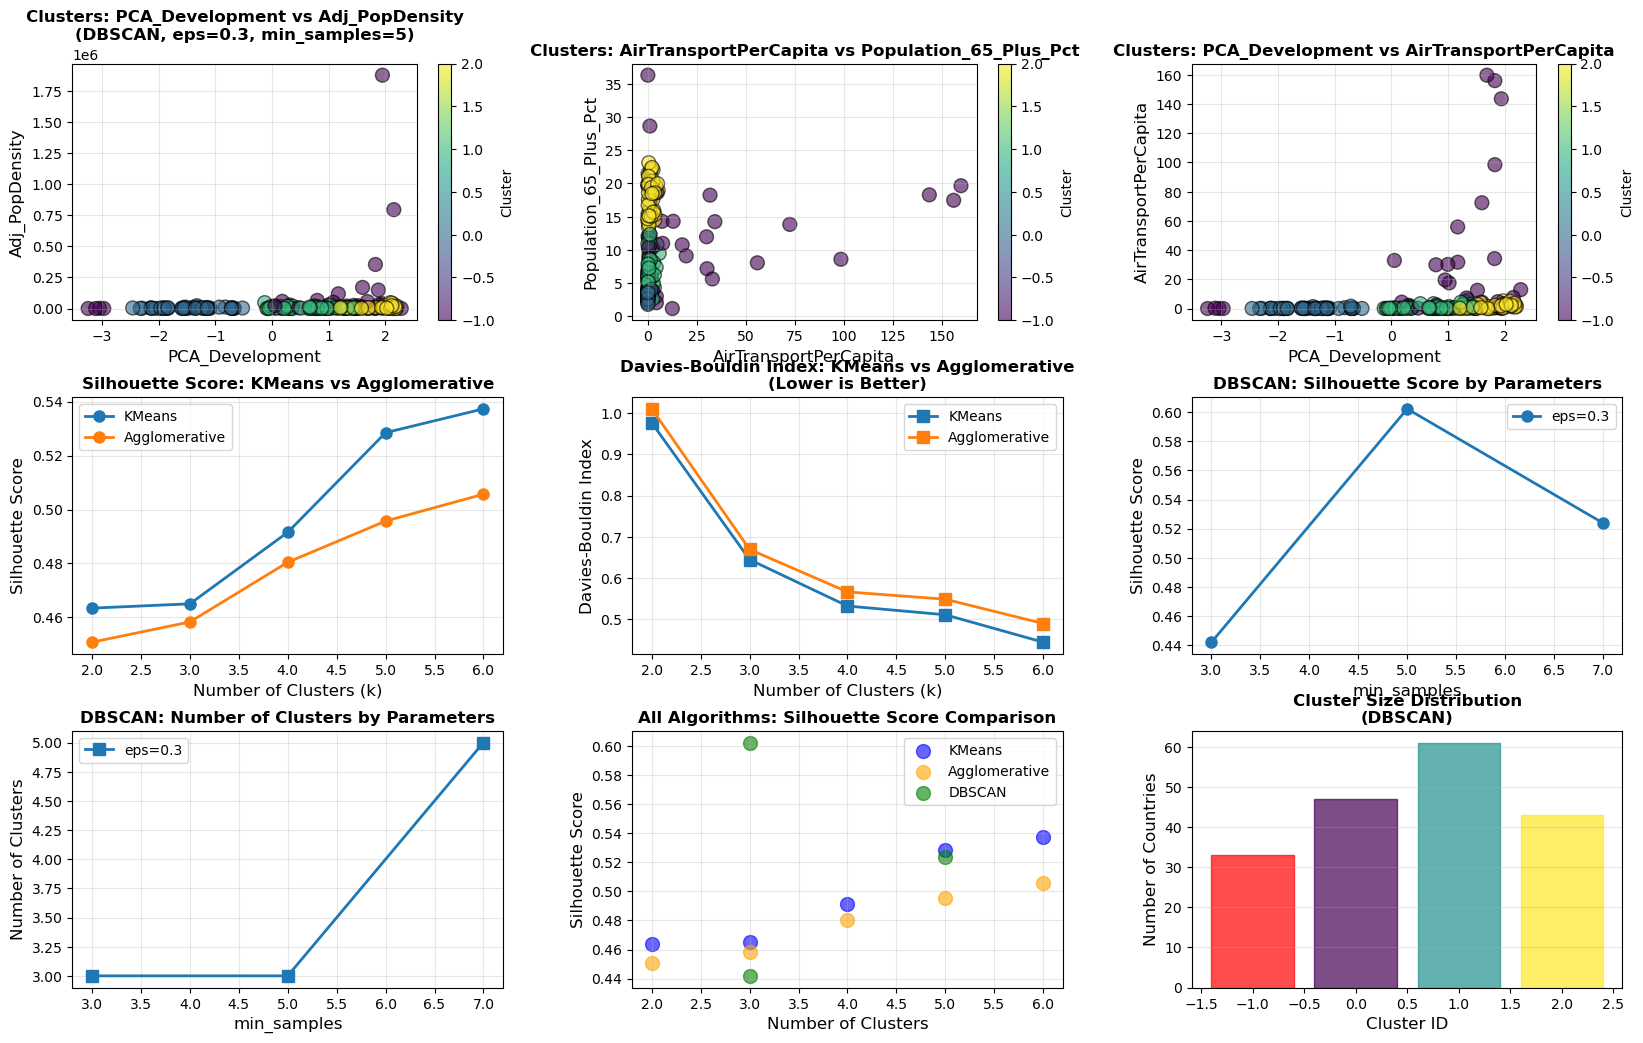


ANALYSIS COMPLETE
Visualization saved as 'clustering_analysis.png'

CLUSTER STATISTICS

Noise (33 countries):
      PCA_Development  Adj_PopDensity  AirTransportPerCapita  \
mean         0.793786   120773.325902              28.638535   
std          1.570812   349070.756636              46.018690   

      Population_65_Plus_Pct  
mean               11.253695  
std                 7.977656  
Countries: Andorra, Bahrain, Barbados, Bermuda, Bosnia and Herzegovina, British Virgin Islands, Cayman Islands, Chad, Dominica, Gibraltar... (+23 more)

Cluster 0 (47 countries):
      PCA_Development  Adj_PopDensity  AirTransportPerCapita  \
mean        -1.446948     4226.598759               0.153882   
std          0.504569     4170.465656               0.307418   

      Population_65_Plus_Pct  
mean                3.404347  
std                 0.987763  
Countries: Afghanistan, Angola, Benin, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Comoros, Cote d'Ivoire... (+37 more)

Cluste

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('../data/interim/dataset_filled_complete.csv')

# ============================================================================
# STEP 1: FEATURE ENGINEERING
# ============================================================================

# Create Adj_PopDensity: Population_Density * Urban_Population_Pct
df['Adj_PopDensity'] = df['Population_Density'] * df['Urban_Population_Pct']

# Create AirTransportPerCapita: Air_Transport_Passengers / Population_Total
df['AirTransportPerCapita'] = df['Air_Transport_Passengers'] / df['Population_Total']

# ============================================================================
# STEP 2: APPLY PCA TO DEVELOPMENT INDICATORS
# ============================================================================

# Select the three features for PCA
pca_features = ['HDI', 'Healthcare_Access_Index', 'No_Improved_Water_Pct']

# Remove rows with missing values in these columns for PCA
df_pca = df[pca_features].dropna()
valid_indices = df_pca.index

# Standardize the features before PCA
scaler_pca = StandardScaler()
pca_features_scaled = scaler_pca.fit_transform(df_pca)

# Apply PCA and extract the first principal component
pca = PCA(n_components=1)
pca_result = pca.fit_transform(pca_features_scaled)

# Add PCA_Development to the dataframe
df['PCA_Development'] = np.nan
df.loc[valid_indices, 'PCA_Development'] = pca_result.flatten()

# Drop the original three columns
df = df.drop(columns=pca_features)

print("\n" + "="*80)
print("PCA TRANSFORMATION COMPLETE")
print("="*80)
print(f"Explained variance by first PC: {pca.explained_variance_ratio_[0]:.4f}")
print(f"Dropped columns: {pca_features}")
print(f"Added column: PCA_Development")

# ============================================================================
# STEP 3: SUBSET DATA FOR YEAR 2019
# ============================================================================

df_2019 = df[df['Year'] == 2019].copy()
print("\n" + "="*80)
print("DATA SUBSET FOR YEAR 2019")
print("="*80)
print(f"Number of countries in 2019: {len(df_2019)}")

# ============================================================================
# STEP 4: PREPARE CLUSTERING FEATURES
# ============================================================================

# Features for clustering
clustering_features = ['PCA_Development', 'Adj_PopDensity', 
                       'AirTransportPerCapita', 'Population_65_Plus_Pct']

# Remove rows with missing values in clustering features
df_clustering = df_2019[['Country Name'] + clustering_features].dropna()
print(f"\nCountries with complete data for clustering: {len(df_clustering)}")

# Standardize features for clustering
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(df_clustering[clustering_features])

# ============================================================================
# STEP 5: CLUSTERING WITH MULTIPLE ALGORITHMS AND PARAMETERS
# ============================================================================

print("\n" + "="*80)
print("CLUSTERING ANALYSIS")
print("="*80)

# Test different numbers of clusters
k_values = [2, 3, 4, 5, 6]
results = []

# KMeans Clustering
print("\n--- KMeans Clustering ---")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    
    results.append({
        'Algorithm': 'KMeans',
        'n_clusters': k,
        'params': f'k={k}',
        'Silhouette Score': sil_score,
        'Davies-Bouldin Index': db_score
    })
    
    print(f"k={k}: Silhouette={sil_score:.4f}, Davies-Bouldin={db_score:.4f}")

# Agglomerative Clustering
print("\n--- Agglomerative Clustering ---")
for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    
    results.append({
        'Algorithm': 'Agglomerative',
        'n_clusters': k,
        'params': f'k={k}',
        'Silhouette Score': sil_score,
        'Davies-Bouldin Index': db_score
    })
    
    print(f"k={k}: Silhouette={sil_score:.4f}, Davies-Bouldin={db_score:.4f}")

# DBSCAN Clustering
print("\n--- DBSCAN Clustering ---")
# Test different eps and min_samples values
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
min_samples_values = [3, 5, 7]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # DBSCAN can produce noise points (label=-1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Only calculate metrics if we have at least 2 clusters and not all points are noise
        if n_clusters >= 2 and n_noise < len(labels) - 1:
            # For silhouette score, we need to exclude noise points
            if n_noise > 0:
                mask = labels != -1
                if len(set(labels[mask])) >= 2:
                    sil_score = silhouette_score(X_scaled[mask], labels[mask])
                    db_score = davies_bouldin_score(X_scaled[mask], labels[mask])
                else:
                    continue
            else:
                sil_score = silhouette_score(X_scaled, labels)
                db_score = davies_bouldin_score(X_scaled, labels)
            
            results.append({
                'Algorithm': 'DBSCAN',
                'n_clusters': n_clusters,
                'params': f'eps={eps}, min_samples={min_samples}',
                'Silhouette Score': sil_score,
                'Davies-Bouldin Index': db_score,
                'n_noise': n_noise
            })
            
            print(f"eps={eps}, min_samples={min_samples}: "
                  f"clusters={n_clusters}, noise={n_noise}, "
                  f"Silhouette={sil_score:.4f}, Davies-Bouldin={db_score:.4f}")
        else:
            print(f"eps={eps}, min_samples={min_samples}: "
                  f"clusters={n_clusters}, noise={n_noise} (skipped - insufficient clusters)")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("CLUSTERING EVALUATION SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Find best configuration (highest silhouette score)
best_config = results_df.loc[results_df['Silhouette Score'].idxmax()]
print(f"\nBest configuration: {best_config['Algorithm']} with {best_config['params']}")
print(f"Number of clusters: {int(best_config['n_clusters'])}")
print(f"Silhouette Score: {best_config['Silhouette Score']:.4f}")

# ============================================================================
# STEP 6: APPLY BEST CLUSTERING AND ADD LABELS
# ============================================================================

# Use the best configuration
best_algo = best_config['Algorithm']
best_params = best_config['params']

if best_algo == 'KMeans':
    best_k = int(best_config['n_clusters'])
    final_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    final_labels = final_model.fit_predict(X_scaled)
elif best_algo == 'Agglomerative':
    best_k = int(best_config['n_clusters'])
    final_model = AgglomerativeClustering(n_clusters=best_k)
    final_labels = final_model.fit_predict(X_scaled)
else:  # DBSCAN
    # Parse eps and min_samples from params string
    params_dict = {}
    for param in best_params.split(', '):
        key, value = param.split('=')
        params_dict[key] = float(value) if key == 'eps' else int(value)
    
    final_model = DBSCAN(eps=params_dict['eps'], min_samples=params_dict['min_samples'])
    final_labels = final_model.fit_predict(X_scaled)

df_clustering['Cluster'] = final_labels

print("\n" + "="*80)
print("CLUSTER ASSIGNMENTS")
print("="*80)
print(df_clustering[['Country Name', 'Cluster']].sort_values('Cluster'))

# Count points in each cluster
print("\nCluster sizes:")
print(df_clustering['Cluster'].value_counts().sort_index())

# ============================================================================
# STEP 7: VISUALIZATION
# ============================================================================

# Create visualizations
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: PCA_Development vs Adj_PopDensity
ax1 = fig.add_subplot(gs[0, 0])
scatter1 = ax1.scatter(df_clustering['PCA_Development'], 
                       df_clustering['Adj_PopDensity'],
                       c=df_clustering['Cluster'], 
                       cmap='viridis', 
                       s=100, 
                       alpha=0.6,
                       edgecolors='black')
ax1.set_xlabel('PCA_Development', fontsize=12)
ax1.set_ylabel('Adj_PopDensity', fontsize=12)
ax1.set_title(f'Clusters: PCA_Development vs Adj_PopDensity\n({best_algo}, {best_params})', 
              fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster')
ax1.grid(True, alpha=0.3)

# Plot 2: AirTransportPerCapita vs Population_65_Plus_Pct
ax2 = fig.add_subplot(gs[0, 1])
scatter2 = ax2.scatter(df_clustering['AirTransportPerCapita'], 
                       df_clustering['Population_65_Plus_Pct'],
                       c=df_clustering['Cluster'], 
                       cmap='viridis', 
                       s=100, 
                       alpha=0.6,
                       edgecolors='black')
ax2.set_xlabel('AirTransportPerCapita', fontsize=12)
ax2.set_ylabel('Population_65_Plus_Pct', fontsize=12)
ax2.set_title(f'Clusters: AirTransportPerCapita vs Population_65_Plus_Pct', 
              fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Cluster')
ax2.grid(True, alpha=0.3)

# Plot 3: PCA_Development vs AirTransportPerCapita
ax3 = fig.add_subplot(gs[0, 2])
scatter3 = ax3.scatter(df_clustering['PCA_Development'], 
                       df_clustering['AirTransportPerCapita'],
                       c=df_clustering['Cluster'], 
                       cmap='viridis', 
                       s=100, 
                       alpha=0.6,
                       edgecolors='black')
ax3.set_xlabel('PCA_Development', fontsize=12)
ax3.set_ylabel('AirTransportPerCapita', fontsize=12)
ax3.set_title(f'Clusters: PCA_Development vs AirTransportPerCapita', 
              fontsize=12, fontweight='bold')
plt.colorbar(scatter3, ax=ax3, label='Cluster')
ax3.grid(True, alpha=0.3)

# Plot 4: Silhouette Scores - KMeans vs Agglomerative
ax4 = fig.add_subplot(gs[1, 0])
for algo in ['KMeans', 'Agglomerative']:
    algo_results = results_df[results_df['Algorithm'] == algo]
    ax4.plot(algo_results['n_clusters'], 
             algo_results['Silhouette Score'], 
             marker='o', 
             linewidth=2, 
             markersize=8,
             label=algo)
ax4.set_xlabel('Number of Clusters (k)', fontsize=12)
ax4.set_ylabel('Silhouette Score', fontsize=12)
ax4.set_title('Silhouette Score: KMeans vs Agglomerative', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Davies-Bouldin Index - KMeans vs Agglomerative
ax5 = fig.add_subplot(gs[1, 1])
for algo in ['KMeans', 'Agglomerative']:
    algo_results = results_df[results_df['Algorithm'] == algo]
    ax5.plot(algo_results['n_clusters'], 
             algo_results['Davies-Bouldin Index'], 
             marker='s', 
             linewidth=2, 
             markersize=8,
             label=algo)
ax5.set_xlabel('Number of Clusters (k)', fontsize=12)
ax5.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax5.set_title('Davies-Bouldin Index: KMeans vs Agglomerative\n(Lower is Better)', 
              fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: DBSCAN Silhouette Scores
ax6 = fig.add_subplot(gs[1, 2])
dbscan_results = results_df[results_df['Algorithm'] == 'DBSCAN']
if len(dbscan_results) > 0:
    # Group by eps value
    for eps in dbscan_results['params'].str.extract(r'eps=([\d.]+)')[0].unique():
        eps_data = dbscan_results[dbscan_results['params'].str.contains(f'eps={eps}')]
        min_samples_vals = eps_data['params'].str.extract(r'min_samples=(\d+)')[0].astype(int)
        ax6.plot(min_samples_vals, 
                 eps_data['Silhouette Score'], 
                 marker='o', 
                 linewidth=2, 
                 markersize=8,
                 label=f'eps={eps}')
    ax6.set_xlabel('min_samples', fontsize=12)
    ax6.set_ylabel('Silhouette Score', fontsize=12)
    ax6.set_title('DBSCAN: Silhouette Score by Parameters', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

# Plot 7: DBSCAN Number of Clusters
ax7 = fig.add_subplot(gs[2, 0])
if len(dbscan_results) > 0:
    for eps in dbscan_results['params'].str.extract(r'eps=([\d.]+)')[0].unique():
        eps_data = dbscan_results[dbscan_results['params'].str.contains(f'eps={eps}')]
        min_samples_vals = eps_data['params'].str.extract(r'min_samples=(\d+)')[0].astype(int)
        ax7.plot(min_samples_vals, 
                 eps_data['n_clusters'], 
                 marker='s', 
                 linewidth=2, 
                 markersize=8,
                 label=f'eps={eps}')
    ax7.set_xlabel('min_samples', fontsize=12)
    ax7.set_ylabel('Number of Clusters', fontsize=12)
    ax7.set_title('DBSCAN: Number of Clusters by Parameters', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

# Plot 8: All Algorithms Silhouette Score Comparison
ax8 = fig.add_subplot(gs[2, 1])
algo_colors = {'KMeans': 'blue', 'Agglomerative': 'orange', 'DBSCAN': 'green'}
for algo in results_df['Algorithm'].unique():
    algo_data = results_df[results_df['Algorithm'] == algo].sort_values('n_clusters')
    ax8.scatter(algo_data['n_clusters'], 
                algo_data['Silhouette Score'],
                s=100,
                alpha=0.6,
                label=algo,
                color=algo_colors.get(algo, 'gray'))
ax8.set_xlabel('Number of Clusters', fontsize=12)
ax8.set_ylabel('Silhouette Score', fontsize=12)
ax8.set_title('All Algorithms: Silhouette Score Comparison', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# Plot 9: Cluster size distribution
ax9 = fig.add_subplot(gs[2, 2])
cluster_sizes = df_clustering['Cluster'].value_counts().sort_index()
bars = ax9.bar(cluster_sizes.index, cluster_sizes.values, alpha=0.7, edgecolor='black')
# Color bars by cluster
for i, bar in enumerate(bars):
    cluster_id = cluster_sizes.index[i]
    if cluster_id == -1:
        bar.set_color('red')
        bar.set_label('Noise')
    else:
        bar.set_color(plt.cm.viridis(cluster_id / max(cluster_sizes.index)))
ax9.set_xlabel('Cluster ID', fontsize=12)
ax9.set_ylabel('Number of Countries', fontsize=12)
ax9.set_title(f'Cluster Size Distribution\n({best_algo})', fontsize=12, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='y')

plt.savefig('../figures/clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("Visualization saved as 'clustering_analysis.png'")

# Display cluster statistics
print("\n" + "="*80)
print("CLUSTER STATISTICS")
print("="*80)
for cluster_id in sorted(df_clustering['Cluster'].unique()):
    cluster_data = df_clustering[df_clustering['Cluster'] == cluster_id]
    cluster_label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"\n{cluster_label} ({len(cluster_data)} countries):")
    print(cluster_data[clustering_features].describe().loc[['mean', 'std']])
    print(f"Countries: {', '.join(cluster_data['Country Name'].values[:10])}" + 
          (f"... (+{len(cluster_data)-10} more)" if len(cluster_data) > 10 else ""))

# Analysis Report

**PCA Transformation**

The first principal component accounts for 88.92% of the variance in the three development indicators:

 - HDI (Human Development Index)
 - Healthcare_Access_Index
 - No_Improved_Water_Pct

This high explained variance indicates a high degree of correlation between these three indicators and can be effectively represented by a single dimension, PCA_Development, which serves as a composite development indicator.

**Comparison of Clustering Algorithms**

| Algorithm       | Best params         | Silhouette Score | Davies-Bouldin Index |
|-----------------|-----------------------|------------------|----------------------|
| DBSCAN          | eps=0.3, min_samples=5 | **0.6024**     | 0.4980               |
| KMeans          | k=6                   | 0.5373           | **0.4443**         |
| Agglomerative   | k=6                   | 0.5057           | 0.4896               |

K-Means:
Performance steadily improves with increasing number of clusters (from k=2 to k=6)
Best performance with k=6 and Silhouette = 0.54
Best Davis-Bouldin Index score (0.4443), indicating well-separated, compact clusters
Assumes spherical clusters of equal size

Agglomerative Clustering:
Similar trend with K-Means, but slightly lower performance
Best at k=6 with Silhouette = 0.5057
More flexible than K-Means regarding cluster shape, but this advantage was not exploited here.
The hierarchical structure allows for different levels of granularity.

DBSCAN:
Highest Silhouette Score (0.6024) with eps=0.3, min_samples=5
Identified 33 outlier countries (18% of the data) as noise points.
Only 3 valid clusters were generated with this configuration.

**Optimal Clustering Solution: DBSCAN**

Cluster Distribution:
Cluster 0: 47 countries (26%)
Cluster 1: 61 countries (33%) 
Cluster 2: 43 countries (23%)
Noise (-1): 33 countries (18%) (outliers)

Why DBSCAN is the best for this task:

 - Excellent Separation: A Silhouette Score of 0.6024 indicates that the clusters are well separated and internally cohesive.
 - Outlier Detection: 33 outlier countries were identified that did not fit typical patterns (e.g., Kuwait, Qatar, Palau).
 - No forced clustering: Unlike the K-means/Agglomerative method, DBSCAN does not force outliers into clusters.

Outlier countries (noise) likely represent:
Small, oil-rich states (Kuwait, Qatar) with extreme values;
Island states with unique demographic patterns (Palau);
Countries with unusual combinations of development indicators.


**Cluster Interpretation and Significance**

Cluster analysis identifies four distinct country groups (including the "noise" group detected by DBSCAN).
Each cluster exhibits a characteristic combination of development, demographic structure, and transport activity.

**"Noise" Group (33 countries)**

*Distinguishing Features:* 

High dispersion of all characteristics, wide range of development levels (PCA_Development std = 1.57) from small island states to microeconomies.

Small population - outliers such as Gibraltar or the Cayman Islands distort the average values.

This group consists of microstates and outliers whose socioeconomic patterns that are hard to generalize. Their data exhibit irregular behavior, as small absolute changes lead to significant fluctuations in per capita indicators.

*Key points:* 

- Global indices often misrepresent small states.

- Policy development for such countries requires specialized estimation models rather than global normalization.

- Development and resource allocation models should avoid universal cluster logic.

**Cluster 0: Low Development, Low Mobility, Young Population (47 countries)**

*Distinguishing Features:*

Lowest PCA Development Index (-1.45) low HDI and access to healthcare.

Minimal transport activity (0.15 passengers per capita) limited air connectivity.

Very young population (3.4% aged 65+) demographic potential, but high dependency burden. Moderate adjusted population density (~4,200) predominantly rural, agricultural economy.

*Key points:*

The cluster represents low-income developing countries, primarily in sub-Saharan Africa and parts of Southeast Asia.
These countries face structural challenges such as poor transportation infrastructure, limited access to healthcare, and high fertility rates.

In these countries, epidemics probably spread slowly due to low population mobility, but weak infrastructure makes it difficult to fight it.

International development agencies can target these countries for investment in infrastructure and healthcare.

The private sector sees potential in emerging markets with young populations but low purchasing power.

Policy focus: inclusive growth and improved access to healthcare.

**Cluster 1: Emerging and Middle-Income Countries (61 countries)**

*Distinguishing Features:*

Moderate PCA_Development (~0.74) - increasing HDI and access to healthcare.

Balanced demographics (6.7% aged 65+) - early stages of the transition to aging.

Moderate transport activity (0.82) - expanding mobility networks.

Diverse geography and population density (~6,700) - high volatility, often with developed urban centers.

*Key points:*

This cluster includes countries with emerging economies from Latin America, South and East Asia, and some regions of Eastern Europe.
They combine economic growth with rising inequality and environmental pressures.

Key policy areas: energy efficiency, healthcare quality, urban planning.

Strategic note: These countries are in the global middle their trajectory will determine future global demand and emissions.

**Cluster 2: High-income and aging economies (43 countries)**

Distinguishing features:

Highest PCA Development Index (1.73) - very high HDI and healthcare coverage.

Oldest population (18% aged 65+) - aging economies with labor market constraints.

High transport activity (1.46) - developed international and domestic transport networks.

Moderate population density (~9,000), but with efficient infrastructure.

Key points:

Represents advanced industrial economies, OECD countries with advanced healthcare and aging populations.

They are highly globalized, characterized by high air mobility and a service-oriented economy.

Epidemics can spread rapidly in these countries due to high population mobility, older population structure can lead to higher mortality rates.

Governments face the need to adapt social systems to an aging population.

Private sector opportunities in medical technology, automation, and age-friendly infrastructure.

Global context: These countries influence international policy standards and the diffusion of innovation.

| Cluster | Development | Population Age | Transport Activity | Policy Focus |
| ------- | --------------- | ---------- | ------------------ | ------------------------------ |
| Noise | Highly variable | Variable | Irregular | Custom evaluation |
| 0 | Low | Very young | Minimal | Infrastructure, health |
| 1 | Medium | Moderate | Growing | Sustainable transition |
| 2 | High | Aged | High | Innovation, healthcare systems |

Overall, the clusters highlight that demographic structure, mobility, and development are interlinked dimensions shaping national vulnerability and capacity information that can inform international cooperation and targeted policy interventions.


# Visual Clustering Analysis


FINAL DBSCAN CLUSTERING (eps=0.3, min_samples=5)
Detected clusters: 3
Noise points: 33
Silhouette Score (no noise): 0.6024
Davies-Bouldin Index (no noise): 0.4980

Clustered dataset saved to '../data/processed/clustered_2019_DBSCAN.csv'


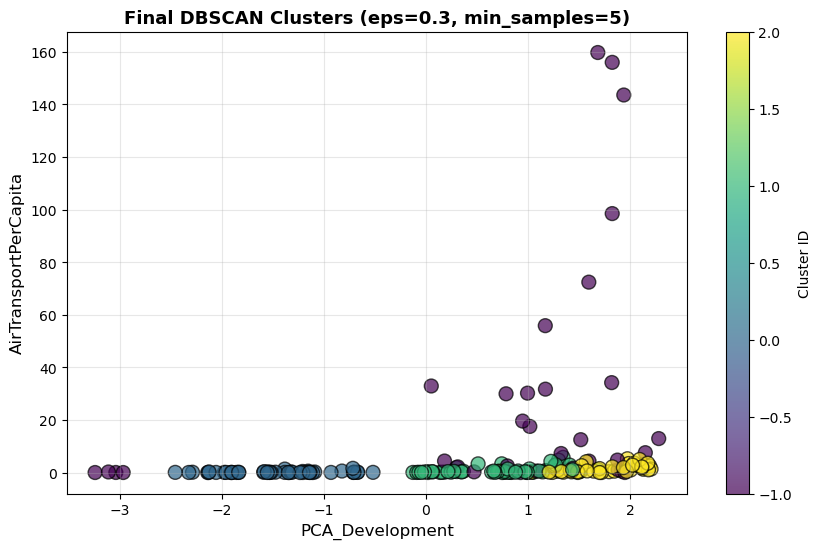


DBSCAN CLUSTER SUMMARY
               PCA_Development        Adj_PopDensity              \
                          mean    std           mean         std   
Cluster_DBSCAN                                                     
-1                       0.794  1.571     120773.326  349070.757   
 0                      -1.447  0.505       4226.599    4170.466   
 1                       0.738  0.495       6708.819    8025.735   
 2                       1.730  0.388       9084.752   10781.197   

               AirTransportPerCapita         Population_65_Plus_Pct         
                                mean     std                   mean    std  
Cluster_DBSCAN                                                              
-1                            28.639  46.019                 11.254  7.978  
 0                             0.154   0.307                  3.404  0.988  
 1                             0.824   1.253                  6.712  2.563  
 2                             1.466 

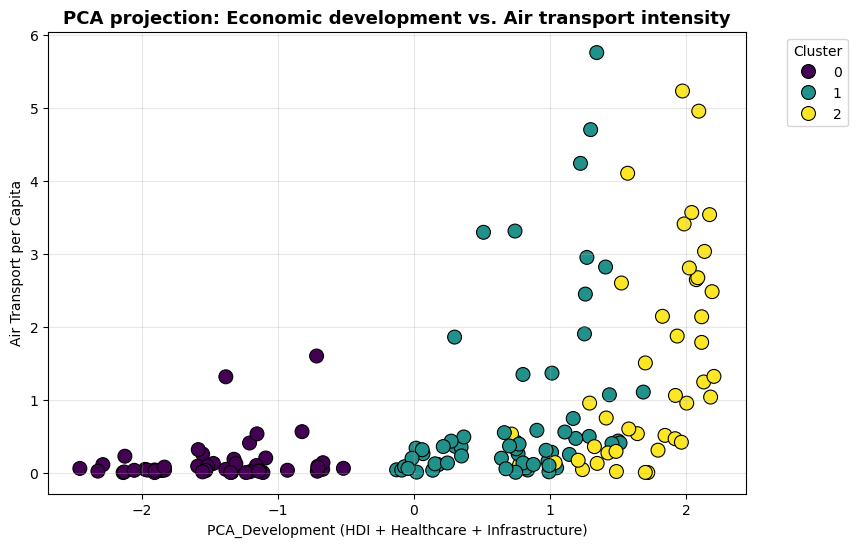

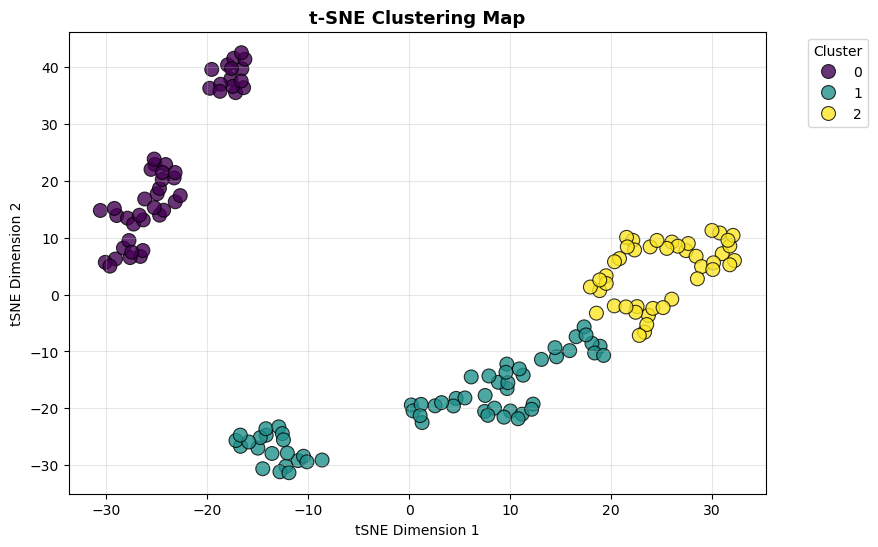

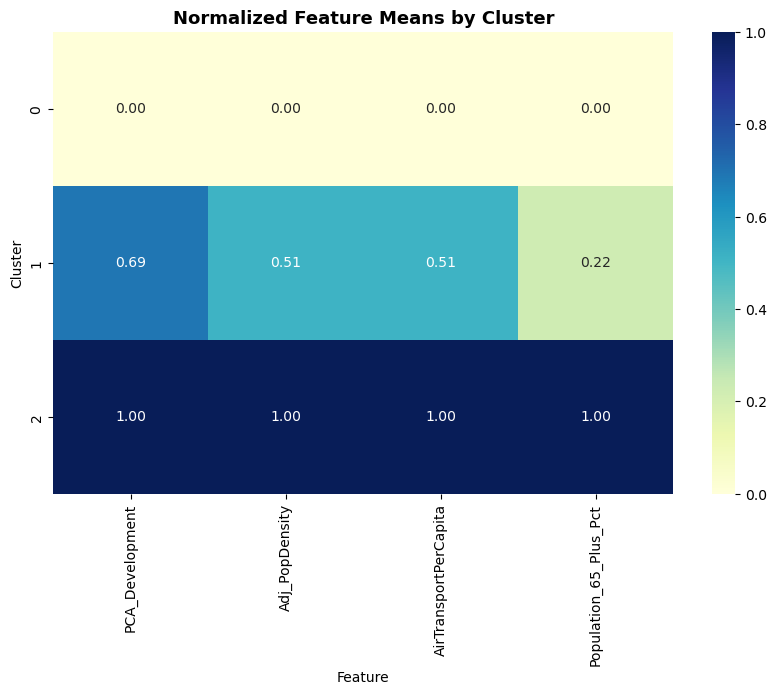

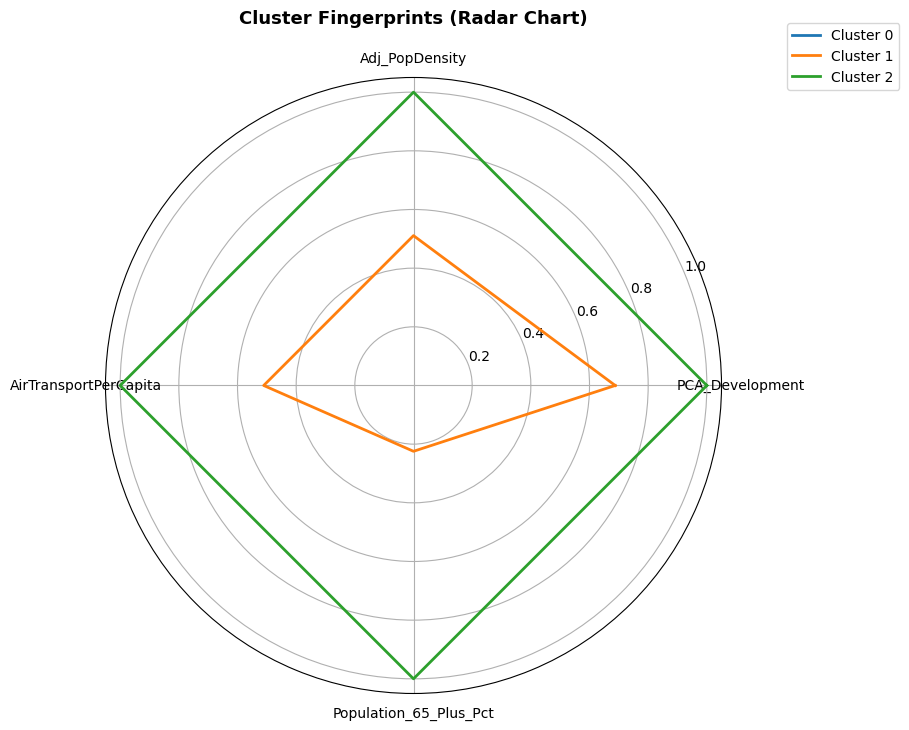

In [10]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from math import pi

# ============================================================================
# STEP 8: FINAL DBSCAN MODEL (eps=0.3, min_samples=5)
# ============================================================================

print("\n" + "="*80)
print("FINAL DBSCAN CLUSTERING (eps=0.3, min_samples=5)")
print("="*80)

# Initialize and fit DBSCAN with chosen parameters
final_dbscan = DBSCAN(eps=0.3, min_samples=5)
final_labels = final_dbscan.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clustering['Cluster_DBSCAN'] = final_labels

# Count number of clusters (excluding noise)
n_clusters = len(set(final_labels)) - (1 if -1 in final_labels else 0)
n_noise = list(final_labels).count(-1)

print(f"Detected clusters: {n_clusters}")
print(f"Noise points: {n_noise}")

# Calculate Silhouette and Davies-Bouldin scores (excluding noise)
mask = final_labels != -1
if n_clusters >= 2 and mask.sum() > 2:
    sil_score = silhouette_score(X_scaled[mask], final_labels[mask])
    db_score = davies_bouldin_score(X_scaled[mask], final_labels[mask])
    print(f"Silhouette Score (no noise): {sil_score:.4f}")
    print(f"Davies-Bouldin Index (no noise): {db_score:.4f}")
else:
    print("Not enough clusters for Silhouette/Davies-Bouldin computation.")

# ============================================================================
# STEP 9: SAVE CLUSTER ASSIGNMENTS
# ============================================================================

# Merge cluster labels back into the main 2019 dataset
df_2019_clusters = df_2019.merge(df_clustering[['Country Name', 'Cluster_DBSCAN']],
                                 on='Country Name', how='left')

# Save for later analysis
df_2019_clusters.to_csv('../data/processed/clustered_2019_DBSCAN.csv', index=False)

print("\nClustered dataset saved to '../data/processed/clustered_2019_DBSCAN.csv'")

# ============================================================================
# STEP 10: BASIC VISUAL CHECK
# ============================================================================

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_clustering['PCA_Development'],
    df_clustering['AirTransportPerCapita'],
    c=df_clustering['Cluster_DBSCAN'],
    cmap='viridis',
    s=100,
    edgecolors='black',
    alpha=0.7
)
plt.xlabel('PCA_Development', fontsize=12)
plt.ylabel('AirTransportPerCapita', fontsize=12)
plt.title('Final DBSCAN Clusters (eps=0.3, min_samples=5)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(alpha=0.3)
plt.show()

# ============================================================================
# STEP 11: CLUSTER SUMMARY
# ============================================================================

cluster_summary = (
    df_clustering.groupby('Cluster_DBSCAN')[clustering_features]
    .agg(['mean', 'std'])
    .round(3)
)
print("\n" + "="*80)
print("DBSCAN CLUSTER SUMMARY")
print("="*80)
print(cluster_summary)

print("\nCluster distribution:")
print(df_clustering['Cluster_DBSCAN'].value_counts().sort_index())

# Save cluster summary
cluster_summary.to_csv('../data/processed/cluster_summary_DBSCAN.csv')
print("\nCluster summary saved to '../data/processed/cluster_summary_DBSCAN.csv'")


# ============================================================================
# STEP 12: CLUSTER VISUALIZATION & INSIGHTS
# ============================================================================

# Prepare data
vis_df = df_clustering.copy()
valid_mask = vis_df['Cluster_DBSCAN'] != -1  # exclude noise
vis_df = vis_df[valid_mask]

# ----------------------------------------------------------------------------
# 1️⃣ PCA VISUALIZATION
# ----------------------------------------------------------------------------
plt.figure(figsize=(9, 6))
sns.scatterplot(
    x='PCA_Development', y='AirTransportPerCapita',
    hue='Cluster_DBSCAN', palette='viridis', data=vis_df, s=100, edgecolor='black'
)
plt.title('PCA projection: Economic development vs. Air transport intensity', fontsize=13, fontweight='bold')
plt.xlabel('PCA_Development (HDI + Healthcare + Infrastructure)')
plt.ylabel('Air Transport per Capita')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()

# ----------------------------------------------------------------------------
# 2️⃣ t-SNE VISUALIZATION (nonlinear embedding)
# ----------------------------------------------------------------------------
tsne = TSNE(n_components=2, perplexity=10, random_state=42, n_iter=2000)
tsne_result = tsne.fit_transform(X_scaled[valid_mask])

tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'])
tsne_df['Cluster_DBSCAN'] = vis_df['Cluster_DBSCAN'].values

plt.figure(figsize=(9, 6))
sns.scatterplot(
    x='tSNE1', y='tSNE2',
    hue='Cluster_DBSCAN', palette='viridis', data=tsne_df,
    s=100, edgecolor='black', alpha=0.8
)
plt.title('t-SNE Clustering Map', fontsize=13, fontweight='bold')
plt.xlabel('tSNE Dimension 1')
plt.ylabel('tSNE Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()

# ----------------------------------------------------------------------------
# 3️⃣ CLUSTER HEATMAP
# ----------------------------------------------------------------------------
cluster_means = (
    vis_df.groupby('Cluster_DBSCAN')[clustering_features]
    .mean()
    .pipe(lambda df: (df - df.min()) / (df.max() - df.min()))  # normalize 0-1 for visualization
)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Normalized Feature Means by Cluster', fontsize=13, fontweight='bold')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.show()


# ----------------------------------------------------------------------------
# 4️⃣ RADAR CHARTS (Cluster Fingerprints)
# ----------------------------------------------------------------------------
# Normalize data for radar
scaler = MinMaxScaler()
scaled_means = scaler.fit_transform(cluster_means)
radar_df = pd.DataFrame(scaled_means, columns=cluster_means.columns, index=cluster_means.index)

features = radar_df.columns.tolist()
num_vars = len(features)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # complete circle

plt.figure(figsize=(8, 8))
for i, row in radar_df.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Cluster {i}', linewidth=2)
plt.xticks(angles[:-1], features, fontsize=10)
plt.title('Cluster Fingerprints (Radar Chart)', fontsize=13, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

# ============================================================================
# END OF VISUALIZATION SECTION
# ============================================================================


### PCA scatter: Economic development vs. air-transport intensity

Each point is a country positioned by PCA_Development (x-axis, higher = more developed infrastructure) and AirTransportPerCapita (y-axis, higher = more international mobility), color-coded by cluster.

The figure shows that some countries have significantly more air passengers than others. It also shows that developed countries (marked in yellow) tend to have more air passengers. Countries that are both highly developed and globally connected (far-right, higher y) are more exposed to rapid cross-border introduction of cases due to intense mobility, even if their systems are better able to detect and respond. Conversely, low-development/low-mobility countries may see slower importation but higher local vulnerability once transmission begins.

### t-SNE clustering map

A non-linear projection of countries into two dimensions that preserves neighborhood structure; colors denote the same clusters.
The clusters form well-separated islands without overlaps, indicating distinct country profiles. The separation suggests that combinations of development, density, mobility, and age structure naturally co-occur, creating coherent risk archetypes rather than a continuum. This supports using differentiated preparedness packages tailored to each archetype. Regional or multilateral planning can allocate resources by cluster "islands," enabling pre-packaged interventions (for example mobility-focused controls for one cluster, primary-care strengthening for another).

### Heatmap: Normalized feature means by cluster

Each row is a cluster and each column is one of the four indicators. Cell values are min-max normalized means (0 = lowest among clusters, 1 = highest), with labels shown inside the cells.

- Cluster 2 sits at the ceiling on every feature (1.00 across development, adjusted density, air transport, and 65+ share), representing the "high-everything" profile. 
- Cluster 0 is uniformly at the floor (0.00), capturing the “low-everything” profile. 
- Cluster 1 is intermediate on development (0.69) and both density and mobility (0.51 each), but noticeably lower on elderly share (0.22), indicating a comparatively younger, urbanizing, moderately connected profile.

The heatmap provides a compact checklist to align interventions with each cluster’s dominant drivers.

### Radar chart (cluster fingerprints)

A side-by-side, normalized “fingerprint” of each cluster across PCA_Development, Adj_PopDensity, AirTransportPerCapita, and Population_65_Plus_Pct.

One cluster peaks across nearly all axes (especially development and mobility), another shows moderate density but lower mobility and smaller elderly share, and the third sits uniformly low across indicators. This highlights how clusters differ not by a single metric but by the joint configuration.

The jointly high development–mobility–elderly profile implies high importation pressure and substantial severe-disease risk despite strong systems; the high-density, moderate-mobility profile points to rapid urban transmission potential; the uniformly low profile suggests later introduction but fragile response capacity.

Tailor layered strategies: travel-linked surveillance and surge ICU capacity for high development/mobility; urban-contact reduction and rapid diagnostic distribution for high density; system strengthening, risk communication, and essential supplies for low baseline capacity.


### Overall synthesis and robustness
Taken together, the PCA scatter shows a clear gradient of development paired with mobility, directly tying to importation risk and response capability. The t-SNE map independently confirms that countries cluster into well-separated archetypes, suggesting stable, real structure rather than projection artifacts. The heatmap and radar chart provide compact profiles that explain which specific factors drive each cluster’s risk pattern and make cross-cluster comparisons intuitive. 

# Validation with Pandemic Outcomes

The goal of this section is to test whether the previously identified country clusters show meaningful differences in their **COVID-19 impact patterns**.
Specifically, we examine whether structural characteristics (e.g., urbanization, age structure, connectivity) correlate with **pandemic outcomes such as vaccination progress and excess mortality**.

### Selected Datasets
To perform this validation, we use publicly available datasets from **Our World in Data (OWID)**: 

| Dataset | Description | Purpose in analysis |
|----------|--------------|--------------------|
| **Variable: `excess mortality`** | Daily percentage of deaths above baseline. | Used as a proxy for overall pandemic impact and health system stress. |
| **Variable: `vaccine doses per 100 people`** | Percentage of population vaccinated against COVID-19. | Used to assess the adoption and effectiveness of preventive measures. |

### Why Excess Mortality?

**Measurement bias in confirmed cases** 

Reported infection counts depend heavily on testing capacity and reporting standards. 
Low- and middle-income countries often had limited testing availability and inconsistent case registration, leading to severe undercounting. 
Thus, confirmed cases reflect **testing effort**, not necessarily **true transmission levels**.

**Cross-country comparability** 

Excess mortality measures the **total number of deaths above the expected baseline** from all causes. 
This indicator captures both: 
- Direct COVID-19 deaths (even if unconfirmed), 
- Indirect effects such as healthcare system overload or delayed treatments. 
It is therefore more **robust and comparable across countries**, regardless of testing or diagnostic practices.


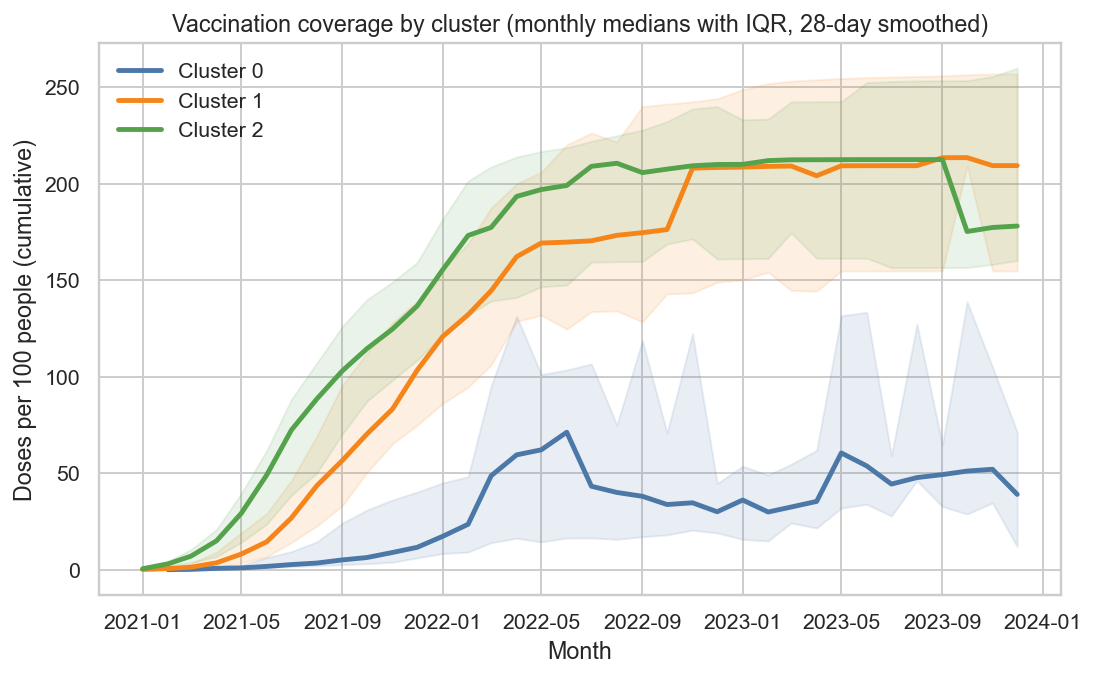

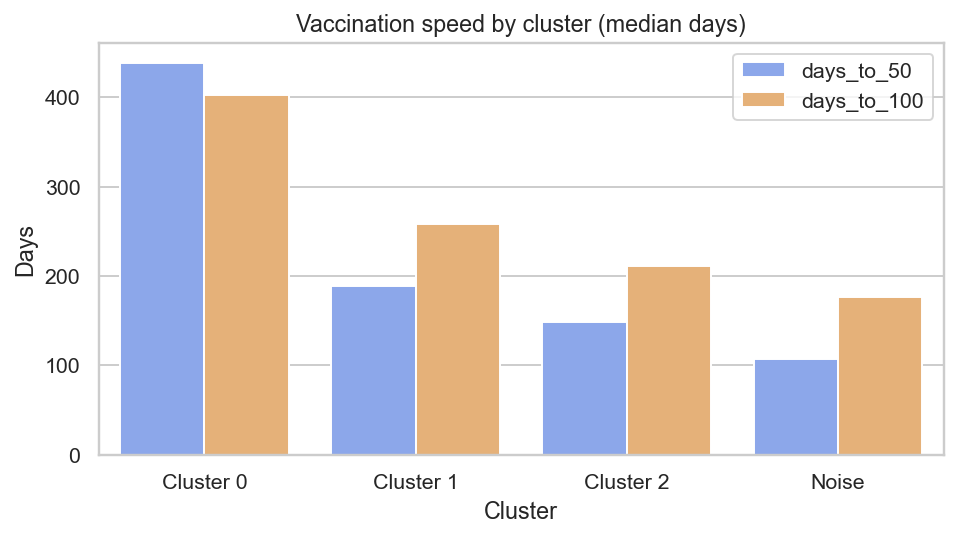

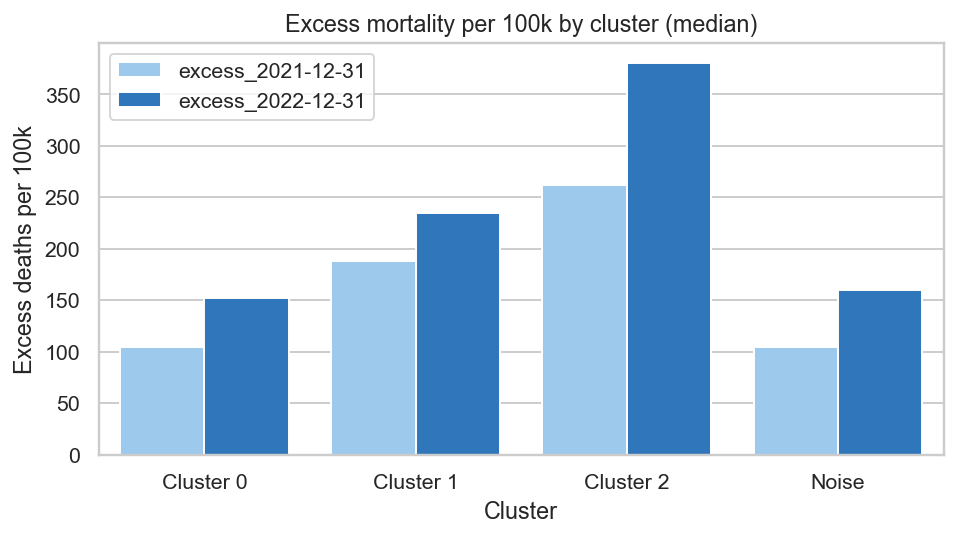


Vaccination speed (median days):
Cluster_Label  days_to_50  days_to_100
    Cluster 0       438.5        402.5
    Cluster 1       189.0        258.5
    Cluster 2       149.0        211.5
        Noise       107.0        176.0

Excess mortality (median per 100k):
Cluster_Label  excess_2021-12-31  excess_2022-12-31
    Cluster 0         104.870013         152.547745
    Cluster 1         188.120320         234.639350
    Cluster 2         261.693200         380.867340
        Noise         105.060960         160.339870


In [26]:



import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 140
sns.set(style="whitegrid")

# ---------- Load ----------

clusters = pd.read_csv("../data/processed/clustered_2019_DBSCAN.csv")
vacc = pd.read_csv("../data/raw/covid-19-vaccine-doses-administered-per-100-people.csv")
excess = pd.read_csv("../data/raw/estimated-cumulative-excess-deaths-per-100000-people-during-covid-19.csv")

# ---------- Standardize ----------
clusters.columns = clusters.columns.str.replace(" ", "_")
vacc.columns = vacc.columns.str.replace(" ", "_")
excess.columns = excess.columns.str.replace(" ", "_")

vacc["Day"] = pd.to_datetime(vacc["Day"], errors="coerce")
excess["Day"] = pd.to_datetime(excess["Day"], errors="coerce")

def norm_name(s):
    if pd.isna(s): return s
    s = str(s).strip()
    s = s.replace("&","and")
    return s

clusters["country_norm"] = clusters["Country_Name"].map(norm_name)
vacc["country_norm"] = vacc["Entity"].map(norm_name)
excess["country_norm"] = excess["Entity"].map(norm_name)

alias = {
    "Russia": "Russian Federation",
    "Russian Fed.": "Russian Federation",
    "Viet Nam": "Vietnam",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Congo (Kinshasa)": "Democratic Republic of the Congo",
    "Congo, Rep.": "Congo",
    "Congo (Brazzaville)": "Congo",
    "Côte d’Ivoire": "Cote d'Ivoire",
    "Cote dIvoire": "Cote d'Ivoire",
    "Cote d'Ivoire": "Cote d'Ivoire",
    "Iran": "Iran, Islamic Republic of",
    "Iran (Islamic Republic of)": "Iran, Islamic Republic of",
    "Lao PDR": "Lao People's Democratic Republic",
    "Laos": "Lao People's Democratic Republic",
    "Syrian Arab Republic": "Syria",
    "United States of America": "United States",
    "USA": "United States",
    "UK": "United Kingdom",
    "Czech Republic": "Czechia",
    "Swaziland": "Eswatini",
    "Cape Verde": "Cabo Verde",
    "Micronesia (Federated States of)": "Micronesia",
    "Bolivia": "Bolivia (Plurinational State of)",
    "Venezuela": "Venezuela (Bolivarian Republic of)",
    "Moldova": "Republic of Moldova",
    "Macedonia, FYR": "North Macedonia",
    "Macedonia": "North Macedonia",
    "Burma": "Myanmar",
    "Bahamas, The": "Bahamas",
    "Gambia, The": "Gambia",
    "Brunei": "Brunei Darussalam",
    "Hong Kong SAR, China": "Hong Kong",
    "Macau SAR, China": "Macao",
    "Timor-Leste": "East Timor",
    "Korea, South": "South Korea",
    "Korea, Rep.": "South Korea",
    "Korea, North": "North Korea",
    "Korea, Dem. People’s Rep.": "North Korea",
}
clusters["country_norm"] = clusters["country_norm"].replace(alias)
vacc["country_norm"] = vacc["country_norm"].replace(alias)
excess["country_norm"] = excess["country_norm"].replace(alias)

# Keep cluster id and a readable label
cluster_labels = {
     0: "Cluster 0",
     1: "Cluster 1",
     2: "Cluster 2",
    -1: "Noise"
}
clusters = clusters[["Country_Name","country_norm","Cluster_DBSCAN"]].drop_duplicates()
clusters["Cluster_Label"] = clusters["Cluster_DBSCAN"].map(cluster_labels).fillna("Other")

# ---------- Vaccination time series per cluster ----------
vcol = "COVID-19_doses_(cumulative,_per_hundred)"
vacc = vacc[["country_norm","Day",vcol]].dropna()
vacc = vacc.merge(clusters[["country_norm","Cluster_Label"]], on="country_norm", how="left")
vacc = vacc.dropna(subset=["Cluster_Label"])

# Smooth per country (7-day rolling on the cumulative is harmless; we’ll median across countries)
vacc = vacc.sort_values(["country_norm","Day"])
vacc["cum_smooth"] = vacc.groupby("country_norm")[vcol].transform(lambda s: s.rolling(7, min_periods=1).mean())

# Build cluster-level median with IQR ribbon per date
cluster_ts = (
    vacc.groupby(["Cluster_Label","Day"])["cum_smooth"]
        .agg(median="median", q25=lambda x: np.nanpercentile(x,25), q75=lambda x: np.nanpercentile(x,75), n="count")
        .reset_index()
)

# ---------- Vaccination speed metrics ----------
def milestone_days(g, thresholds=(50,100)):
    g = g.sort_values("Day")
    start = g["Day"].iloc[0]
    out = {}
    for t in thresholds:
        hit = g.loc[g[vcol] >= t, "Day"]
        out[f"days_to_{t}"] = (hit.iloc[0] - start).days if len(hit) else np.nan
    return pd.Series(out)

speed = (
    vacc.groupby(["country_norm","Cluster_Label"]).apply(milestone_days).reset_index()
)

speed_summary = (
    speed.groupby("Cluster_Label")[["days_to_50","days_to_100"]]
         .median()
         .reset_index()
)

# ---------- Excess mortality snapshots ----------
E = "Cumulative_excess_deaths_per_100,000_people_(central_estimate)"
excess = excess[["country_norm","Day",E]].dropna()
excess = excess.merge(clusters[["country_norm","Cluster_Label"]], on="country_norm", how="left")
excess = excess.dropna(subset=["Cluster_Label"])

def snapshot(df, date_str):
    d = pd.to_datetime(date_str)
    g = df[df["Day"]<=d].sort_values("Day").groupby(["country_norm","Cluster_Label"])[E].last().reset_index()
    g.rename(columns={E:f"excess_{date_str}"}, inplace=True)
    return g

snap_2021 = snapshot(excess, "2021-12-31")
snap_2022 = snapshot(excess, "2022-12-31")
mort = snap_2021.merge(snap_2022, on=["country_norm","Cluster_Label"], how="outer")

mort_summary = (
    mort.groupby("Cluster_Label")[["excess_2021-12-31","excess_2022-12-31"]]
        .median()
        .reset_index()
)

# ---------- Plot 1: Vaccination rate (coverage over time) ----------
# Clean, stable vaccination coverage plot

from pandas.tseries.offsets import MonthEnd

# 1) Smooth per country (28-day rolling on cumulative) and monthly downsample
vcol = "COVID-19_doses_(cumulative,_per_hundred)"
vacc_clean = (
    vacc[["country_norm","Day",vcol,"Cluster_Label"]]
    .dropna()
    .sort_values(["country_norm","Day"])
)

# Smoothing (28-day)
vacc_clean["cum_smooth28"] = (
    vacc_clean.groupby("country_norm")[vcol]
    .transform(lambda s: s.rolling(28, min_periods=7).mean())
)

# Robust winsorization to limit extreme jumps before aggregation
def winsorize(s, p=0.5):  # clip outer 0.5%
    lo, hi = np.nanpercentile(s, [p, 100-p])
    return s.clip(lo, hi)

vacc_clean["cum_smooth28"] = vacc_clean.groupby("country_norm")["cum_smooth28"].transform(winsorize)

# Monthly end date index
vacc_clean["Month"] = (vacc_clean["Day"] + MonthEnd(0)).dt.to_period("M").dt.to_timestamp()

# 2) Cluster-level monthly median and IQR
cluster_month = (
    vacc_clean.groupby(["Cluster_Label","Month"])["cum_smooth28"]
    .agg(median="median",
         q25=lambda x: np.nanpercentile(x, 25),
         q75=lambda x: np.nanpercentile(x, 75),
         n="count")
    .reset_index()
)

# 3) Optional: focus on the main campaign period to reduce empty tails
start, end = pd.to_datetime("2021-01-01"), pd.to_datetime("2023-12-31")
cluster_month = cluster_month[(cluster_month["Month"]>=start) & (cluster_month["Month"]<=end)]

# 4) Plot with minimal clutter
palette = {
    "Cluster 0": "#4C78A8",
    "Cluster 1": "#F58518",
    "Cluster 2": "#54A24B",
    "Noise": "#9e9e9e"
}

plt.figure(figsize=(8,5))
for cl, g in cluster_month.groupby("Cluster_Label"):
    if cl == "Noise": 
        continue
    g = g.sort_values("Month")
    plt.plot(g["Month"], g["median"], label=cl, color=palette.get(cl,"gray"), linewidth=2.5)
    plt.fill_between(g["Month"], g["q25"], g["q75"], color=palette.get(cl,"gray"), alpha=0.12)

plt.title("Vaccination coverage by cluster (monthly medians with IQR, 28-day smoothed)")
plt.xlabel("Month")
plt.ylabel("Doses per 100 people (cumulative)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()
# ---------- Plot 2: Speed of vaccination ----------
plt.figure(figsize=(7,4))
ax = sns.barplot(
    data=speed_summary.melt(id_vars="Cluster_Label", var_name="metric", value_name="days"),
    x="Cluster_Label", y="days", hue="metric", palette=["#7da0f9","#f7b267"]
)
ax.set_title("Vaccination speed by cluster (median days)")
ax.set_xlabel("Cluster")
ax.set_ylabel("Days")
ax.legend(title="")
plt.tight_layout()
plt.show()

# ---------- Plot 3: Mortality (excess deaths) ----------
plt.figure(figsize=(7,4))
ax = sns.barplot(
    data=mort_summary.melt(id_vars="Cluster_Label", var_name="when", value_name="excess"),
    x="Cluster_Label", y="excess", hue="when", palette=["#90caf9","#1976d2"]
)
ax.set_title("Excess mortality per 100k by cluster (median)")
ax.set_xlabel("Cluster")
ax.set_ylabel("Excess deaths per 100k")
ax.legend(title="")
plt.tight_layout()
plt.show()

# ---------- Quick text tables to print beside plots ----------
print("\nVaccination speed (median days):")
print(speed_summary.sort_values("Cluster_Label").to_string(index=False))

print("\nExcess mortality (median per 100k):")
print(mort_summary.sort_values("Cluster_Label").to_string(index=False))

## Conclusions 
### 1. Vaccination rate (coverage over time)
- Cluster 2 reached high coverage earliest and sustained it which is expectable for developed countries; 

- Cluster 1 followed a similar shape but at a lower level and slower pace, which is also expectable since moderately developed countries also have enough resources for effective vaccination, but not as much as high-income countries; 

- Cluster 0 lagged throughout, with a shallow trajectory and large dispersion, indicating uneven or stop-start campaigns.

### 2. Vaccination speed (time to 50 and 100 doses per 100)

Median time-to-50/100 clearly orders the clusters: 
- Cluster 2 fastest,
- Cluster 1 intermediate,
- Cluster 0 slowest by a wide margin.

The gap between 50 and 100 is also smallest in Cluster 2, suggesting sustained throughput once campaigns start.

### 3. Mortality outcomes (excess deaths per 100k, end‑2021 and end‑2022)

Despite faster vaccination, Cluster 2 records the highest median excess mortality by both checkpoints, consistent with its older age structure and higher importation pressure. Cluster 1 shows lower excess mortality, while Cluster 0 has the lowest medians but wide uncertainty-mixing younger populations with fragile health systems that can produce severe spikes in some members.

Implication: Age structure and connectivity shape the residual burden even with good vaccine access. Cluster 2 needs rapid elderly protection (early boosters, LTCF safeguards, antiviral access) alongside hospital surge. Cluster 1 should prioritize urban wave management (ventilation, timely NPIs, test-to-treat). Cluster 0 requires core clinical readiness (oxygen, pulse oximetry, basic critical care) paired with vaccination to translate doses into mortality reduction.

Cross-cutting interpretation
The ordering is consistent across metrics: faster rollout and higher peak coverage in Cluster 2, intermediate in Cluster 1, and slowest/lowest in Cluster 0. Mortality Yet does not simply mirror coverage, older populations and frequent re‑introductions in Cluster 2 keep the burden high, while lower age in Cluster 0 reduces baseline risk but limited capacity raises tail risk when waves hit.
This confirms that epidemic impact emerges from the joint configuration: mobility affects introduction timing, density drives within‑country acceleration, development determines delivery/clinical capacity, and age structure shapes severity. Clusters are thus actionable archetypes rather than mere statistical groups.

Policy design should be cluster‑specific:
Cluster 2: early border intelligence, rapid booster programs for 60+, strong ICU/oxygen surge, and test-to-treat at scale.
Cluster 1: stabilize supply and last‑mile operations, metro‑area mitigation in peaks, targeted protection of older/at‑risk groups.
Cluster 0: guaranteed vaccine supply plus implementation support, fundamental clinical upgrades (oxygen, staff training), and community surveillance/WASH to blunt prolonged tails.


# Interpretation Insight

While initial expectations suggested that lower-income regions would experience the highest pandemic burden, the clustering analysis indicates the opposite: high-income, highly urbanized, and mobile countries were disproportionately affected.
This pattern likely reflects not data quality issues, but structural differences in exposure and demographics:

Younger populations in low-income countries reduced overall mortality risk.

Lower population mobility and rural residence limited transmission speed.

Global synchronization of lockdowns led many low- and middle-income countries to impose restrictions before widespread transmission, mirroring measures in wealthier nations but facing different baseline risks.

In short, the pandemic’s impact illustrates how global crises propagate through interconnected, unequal systems, where vulnerability is shaped by social structure rather than simple economic rank.
